# Homework 2
## IDS 576 <br>
Name: Isaac Salvador <br>
Email: isalva2@uic.edu <br>
UIN: 6669845132 <br>

Name: Ahreum Kim <br>
Email: akim239@uic.edu <br>
UIN: 653241895 <br>

Name: Sadjad Bazarnovi <br>
Email: sbazar3@uic.edu <br>
UIN: 679314994 <br>

## 1. CNNs and finetuning

### Preprocessing

First we specify some data augmentations with [Transforms V2](https://pytorch.org/vision/stable/auto_examples/plot_transforms_v2.html) for both the training and testing sets. The following transforms are applied to the `train_transform` object:

- `RandomRotation`: Rotates the image between 0 and 30 degrees
  
- `RandomHorizontalFlip`: Randomly flips an image along the horizontal axis
  
- `ToImageTensor`: transforms input image into a `torch.Tensor`
  
- `ConvertImageDtype`: converts elements in tensors to `float32` dtype – necessary for development on M-series MacBooks.
  
- `Normalize`: Normalize tensor values such that the mean and standard deviation of the images become `0.0` and `1.0` respectively. Per-color mean and standard deviation values were calculated w.r.t. this [guide](https://saturncloud.io/blog/how-to-normalize-pytorch-cifar10-images-for-improved-model-performance/).

We instantiate an `unaugmented_transform` object as well to create test and validation validation datasets without any augmentations.

In [1]:
import torch
from torch import mps
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2 as transforms

# make torch deterministic for reproducibility
torch.manual_seed(576)

# set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Torch Device:", device)

# previously calculated normalization values
mean = [0.4934569299, 0.483376652, 0.4471793473]
std = [0.2476211786, 0.2445851415, 0.2626110017]

train_transform = transforms.Compose(
    [
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.ToImageTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(mean, std)
    ]
)

unaugmented_transform = transforms.Compose(
    [
        transforms.ToImageTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(mean, std)
    ]
)

Torch Device: mps


We next download the [CIFAR 10 Dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html) from the pytorch website and apply the transforms. The `unaugumented_set` is 50/50 split into a `test_set` and `val_set` using the `random_split` utility.

In [2]:
import torchvision.datasets as datasets
from torch.utils.data import random_split

train_set = datasets.CIFAR10("./Misc_files/data", train=True, transform=train_transform, download=True)

unaugmented_set = datasets.CIFAR10("./Misc_files/data", train=False, transform=unaugmented_transform, download=True)

test_set, val_set = random_split(unaugmented_set, [0.5, 0.5])

Files already downloaded and verified
Files already downloaded and verified


The train, test, and validation sets are then passed to a `Dataloader` iterable with a common practice `batch_size` of 64:

In [3]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size = 64, shuffle=True)
test_loader = DataLoader(test_set, batch_size = 64, shuffle=False)
val_loader = DataLoader(val_set, batch_size = 64, shuffle=False)

With the datasets finalized we can additionally view some sample instances of the data. Plotting instances of the training set can additionally show the results of of the data augmentations (`RandomRotation` is apparent).

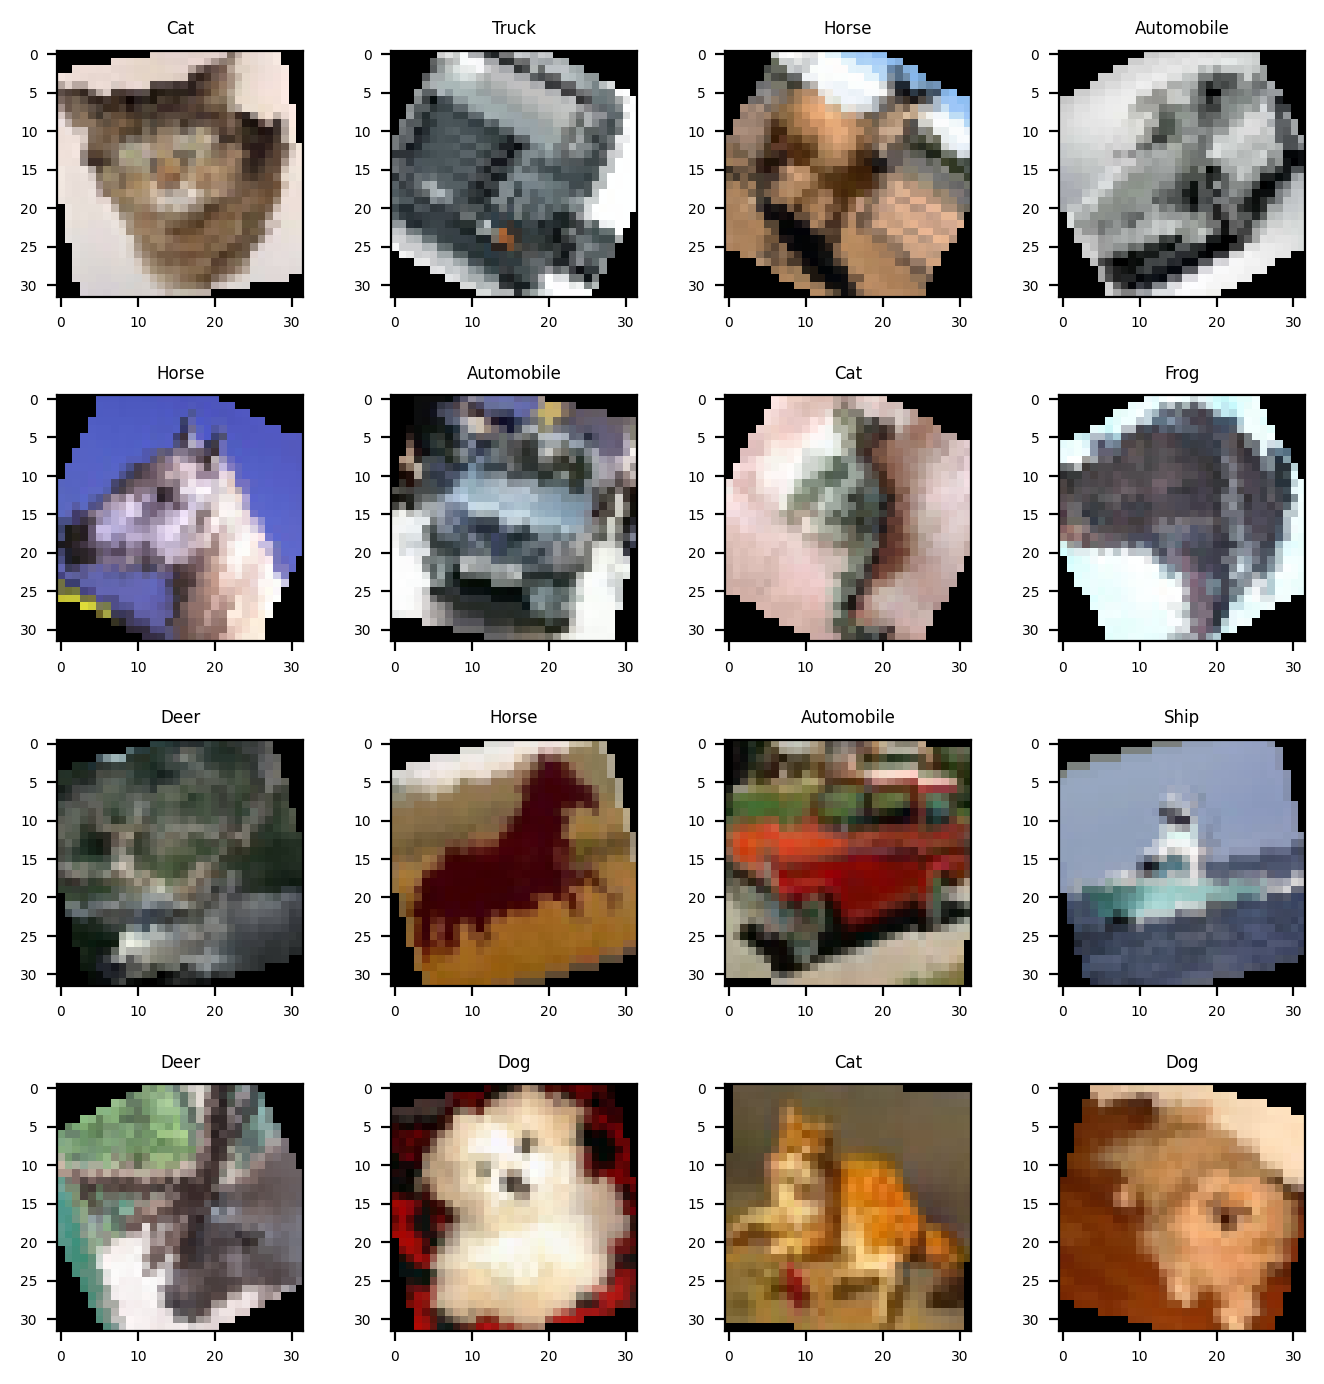

In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 5})

CIFAR10_labels = {
    0: 'Airplane',
    1: 'Automobile',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck'
}

images, labels = next(iter(train_loader))

# Define plot size and DPI
fig = plt.figure(figsize=(8, 8), dpi=200)

# Adjust space between subplots
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.4)

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    ax.set_title(CIFAR10_labels.get(int(labels[i])))
    img = images[i].numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1.)
    plt.imshow(img)

plt.show()

### Transfer learning model

We download the previoulsy constructed `resnet18` model from the `torchvision.models` module and instantiate the model with the default ResNet18 weights. In order to extract features from the data, the paramters in the model are frozen and the final layer `fc` is replaced with a linear layer with 10 outputs using the `torch.nn` linear class.

We additionally specify the loss `criterion` and `optimizer` algorithm for our training loop.
- `CrossEntropyLoss()` loss function was selected to train classification with _C_ classes.
- `Adam` optmizer was selected due to it's performant qualities while training. A learning rate `lr = 1e-3` was selected as it's a common choice that performs well with vision models.

In [5]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights
from torchsummary import summary

# create transfer learning model
resnet18_based = resnet18(weights=ResNet18_Weights.DEFAULT)

# freeze model parameters
for param in resnet18_based.parameters():
    param.requires_grad = False

# replace last fully connected layer
num_ftrs = resnet18_based.fc.in_features
resnet18_based.fc = nn.Linear(num_ftrs, 10)

# move model to GPU
resnet18_based.to(device)

# create loss function
criterion = nn.CrossEntropyLoss()

# select optimizer for training
optimizer = optim.Adam(resnet18_based.fc.parameters(), lr=1e-3)

### Training

We can now devise a training loop for our `resnet18_based` model. Each epoch iteration performs a forward and backward pass per batch in the training data and evaluates on validation data after each epoch. The function returns a dictionary containing the model and relevant training statistics.

In [6]:
from tqdm.notebook import tqdm

# define a function to compute accuracy
def calculate_accuracy(outputs, labels):
    
    softmax = nn.Softmax(dim = 1)
    
    outputs = softmax(outputs)
    
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy

def train_model(model, criterion, optimizer, train_loader: DataLoader, 
                val_loader: DataLoader = None, scheduler = None, num_epochs=25, verbose = 5):

    # model training history
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        model.train()
        
        train_loss = 0
        total_accuracy = 0
        
        # Iterate over data.
        for data in tqdm(train_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # forward pass and loss calculation
            with torch.set_grad_enabled(True):
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)        

                # backward pass
                loss.backward()
                optimizer.step()

            # training loss per batch    
            train_loss += loss.item()
            
            # training statistics
            batch_accuracy = calculate_accuracy(outputs, labels)
            total_accuracy += batch_accuracy
            
        # update scheduler
        if scheduler != None:
            scheduler.step()

        # validation on epoch
        if val_loader != None:

            # training statistics
            val_loss = 0
            val_accuracy = 0

            # set model to evaluation
            model.eval()

            for data in val_loader:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward pass and loss calc
                with torch.no_grad():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()

                val_batch_accuracy = calculate_accuracy(outputs, labels)
                val_accuracy += val_batch_accuracy

        # Calculate average accuracy for the epoch
        epoch_accuracy = total_accuracy / len(train_loader)
        train_acc_history.append(epoch_accuracy)
        
        epoch_loss = train_loss / len(train_loader)
        train_loss_history.append(epoch_loss)
        
        print('Train Loss: {:.4f}\tTrain Accuracy: {:.4f}'.format(epoch_loss, epoch_accuracy))
        
        if val_loader != None:
            
            epoch_val_accuracy = val_accuracy / len(val_loader)
            val_acc_history.append(epoch_val_accuracy)
            
            epoch_val_loss = val_loss / len(val_loader)
            val_loss_history.append(float(epoch_val_loss))
            
            print('Validation Loss: {:.4f}\tValidation Accuracy: {:.4f}\n'.format(epoch_val_loss, epoch_val_accuracy))

    history = {
        "model": model.to("cpu"),
        "train loss": train_loss_history,
        "validation loss": val_loss_history,
        "train accuracy": train_acc_history,
        "validation accuracy": val_acc_history
    }    

    return history


trained_resnet18_based = train_model(resnet18_based, criterion, optimizer, train_loader, val_loader, num_epochs=60)

Epoch 1/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.8830	Train Accuracy: 0.3319
Validation Loss: 1.7966	Validation Accuracy: 0.3675

Epoch 2/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7825	Train Accuracy: 0.3690
Validation Loss: 1.7302	Validation Accuracy: 0.3884

Epoch 3/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7701	Train Accuracy: 0.3718
Validation Loss: 1.7665	Validation Accuracy: 0.3851

Epoch 4/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7623	Train Accuracy: 0.3767
Validation Loss: 1.7544	Validation Accuracy: 0.3813

Epoch 5/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7566	Train Accuracy: 0.3809
Validation Loss: 1.7791	Validation Accuracy: 0.3750

Epoch 6/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7573	Train Accuracy: 0.3802
Validation Loss: 1.7155	Validation Accuracy: 0.4033

Epoch 7/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7524	Train Accuracy: 0.3820
Validation Loss: 1.7631	Validation Accuracy: 0.3758

Epoch 8/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7520	Train Accuracy: 0.3801
Validation Loss: 1.7430	Validation Accuracy: 0.3896

Epoch 9/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7592	Train Accuracy: 0.3790
Validation Loss: 1.7251	Validation Accuracy: 0.3926

Epoch 10/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7582	Train Accuracy: 0.3785
Validation Loss: 1.7171	Validation Accuracy: 0.3944

Epoch 11/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7541	Train Accuracy: 0.3817
Validation Loss: 1.7199	Validation Accuracy: 0.4017

Epoch 12/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7619	Train Accuracy: 0.3775
Validation Loss: 1.7434	Validation Accuracy: 0.3906

Epoch 13/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7538	Train Accuracy: 0.3801
Validation Loss: 1.7295	Validation Accuracy: 0.3950

Epoch 14/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7496	Train Accuracy: 0.3814
Validation Loss: 1.7507	Validation Accuracy: 0.3857

Epoch 15/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7467	Train Accuracy: 0.3827
Validation Loss: 1.7415	Validation Accuracy: 0.3902

Epoch 16/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7634	Train Accuracy: 0.3788
Validation Loss: 1.7231	Validation Accuracy: 0.3839

Epoch 17/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7497	Train Accuracy: 0.3821
Validation Loss: 1.7248	Validation Accuracy: 0.3892

Epoch 18/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7581	Train Accuracy: 0.3781
Validation Loss: 1.7691	Validation Accuracy: 0.3871

Epoch 19/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7537	Train Accuracy: 0.3806
Validation Loss: 1.7207	Validation Accuracy: 0.3930

Epoch 20/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7505	Train Accuracy: 0.3803
Validation Loss: 1.7274	Validation Accuracy: 0.4001

Epoch 21/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7524	Train Accuracy: 0.3789
Validation Loss: 1.7362	Validation Accuracy: 0.3898

Epoch 22/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7544	Train Accuracy: 0.3810
Validation Loss: 1.7376	Validation Accuracy: 0.3912

Epoch 23/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7538	Train Accuracy: 0.3779
Validation Loss: 1.7515	Validation Accuracy: 0.3867

Epoch 24/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7553	Train Accuracy: 0.3823
Validation Loss: 1.7690	Validation Accuracy: 0.3853

Epoch 25/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7529	Train Accuracy: 0.3807
Validation Loss: 1.7499	Validation Accuracy: 0.3819

Epoch 26/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7526	Train Accuracy: 0.3808
Validation Loss: 1.7285	Validation Accuracy: 0.3985

Epoch 27/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7621	Train Accuracy: 0.3757
Validation Loss: 1.7427	Validation Accuracy: 0.3904

Epoch 28/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7528	Train Accuracy: 0.3800
Validation Loss: 1.7926	Validation Accuracy: 0.3821

Epoch 29/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7515	Train Accuracy: 0.3812
Validation Loss: 1.7566	Validation Accuracy: 0.3776

Epoch 30/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7531	Train Accuracy: 0.3806
Validation Loss: 1.7295	Validation Accuracy: 0.3861

Epoch 31/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7517	Train Accuracy: 0.3798
Validation Loss: 1.6977	Validation Accuracy: 0.4074

Epoch 32/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7503	Train Accuracy: 0.3802
Validation Loss: 1.7559	Validation Accuracy: 0.3784

Epoch 33/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7536	Train Accuracy: 0.3790
Validation Loss: 1.7733	Validation Accuracy: 0.3774

Epoch 34/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7549	Train Accuracy: 0.3802
Validation Loss: 1.7230	Validation Accuracy: 0.3912

Epoch 35/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7516	Train Accuracy: 0.3789
Validation Loss: 1.7857	Validation Accuracy: 0.3821

Epoch 36/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7628	Train Accuracy: 0.3784
Validation Loss: 1.7529	Validation Accuracy: 0.3788

Epoch 37/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7567	Train Accuracy: 0.3773
Validation Loss: 1.7682	Validation Accuracy: 0.3764

Epoch 38/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7524	Train Accuracy: 0.3808
Validation Loss: 1.7600	Validation Accuracy: 0.3845

Epoch 39/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7561	Train Accuracy: 0.3780
Validation Loss: 1.7471	Validation Accuracy: 0.3851

Epoch 40/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7543	Train Accuracy: 0.3800
Validation Loss: 1.7630	Validation Accuracy: 0.3821

Epoch 41/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7544	Train Accuracy: 0.3824
Validation Loss: 1.7557	Validation Accuracy: 0.3883

Epoch 42/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7555	Train Accuracy: 0.3794
Validation Loss: 1.7445	Validation Accuracy: 0.3875

Epoch 43/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7480	Train Accuracy: 0.3819
Validation Loss: 1.7538	Validation Accuracy: 0.3807

Epoch 44/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7523	Train Accuracy: 0.3787
Validation Loss: 1.7500	Validation Accuracy: 0.3843

Epoch 45/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7472	Train Accuracy: 0.3835
Validation Loss: 1.7084	Validation Accuracy: 0.4007

Epoch 46/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7536	Train Accuracy: 0.3822
Validation Loss: 1.7343	Validation Accuracy: 0.3956

Epoch 47/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7524	Train Accuracy: 0.3785
Validation Loss: 1.7328	Validation Accuracy: 0.3837

Epoch 48/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7534	Train Accuracy: 0.3793
Validation Loss: 1.7295	Validation Accuracy: 0.3896

Epoch 49/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7531	Train Accuracy: 0.3780
Validation Loss: 1.7478	Validation Accuracy: 0.3792

Epoch 50/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7475	Train Accuracy: 0.3820
Validation Loss: 1.7284	Validation Accuracy: 0.3932

Epoch 51/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7507	Train Accuracy: 0.3813
Validation Loss: 1.7501	Validation Accuracy: 0.3932

Epoch 52/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7506	Train Accuracy: 0.3823
Validation Loss: 1.7229	Validation Accuracy: 0.3932

Epoch 53/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7511	Train Accuracy: 0.3805
Validation Loss: 1.7916	Validation Accuracy: 0.3851

Epoch 54/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7534	Train Accuracy: 0.3798
Validation Loss: 1.7050	Validation Accuracy: 0.3960

Epoch 55/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7554	Train Accuracy: 0.3791
Validation Loss: 1.7747	Validation Accuracy: 0.3766

Epoch 56/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7579	Train Accuracy: 0.3788
Validation Loss: 1.6937	Validation Accuracy: 0.4064

Epoch 57/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7565	Train Accuracy: 0.3800
Validation Loss: 1.7275	Validation Accuracy: 0.3932

Epoch 58/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7571	Train Accuracy: 0.3795
Validation Loss: 1.7008	Validation Accuracy: 0.4072

Epoch 59/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7549	Train Accuracy: 0.3801
Validation Loss: 1.7607	Validation Accuracy: 0.3803

Epoch 60/60


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7535	Train Accuracy: 0.3812
Validation Loss: 1.7346	Validation Accuracy: 0.3958



The `trained_classifier` dictionary can now be passed to the `model_history()` function to plot accuracy and loss history.

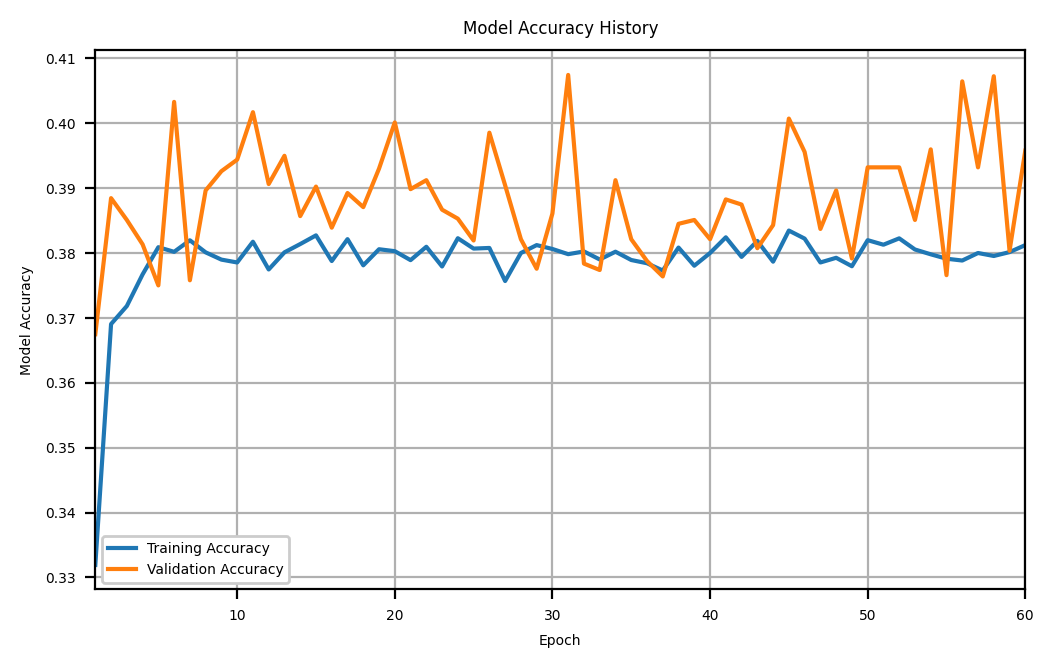

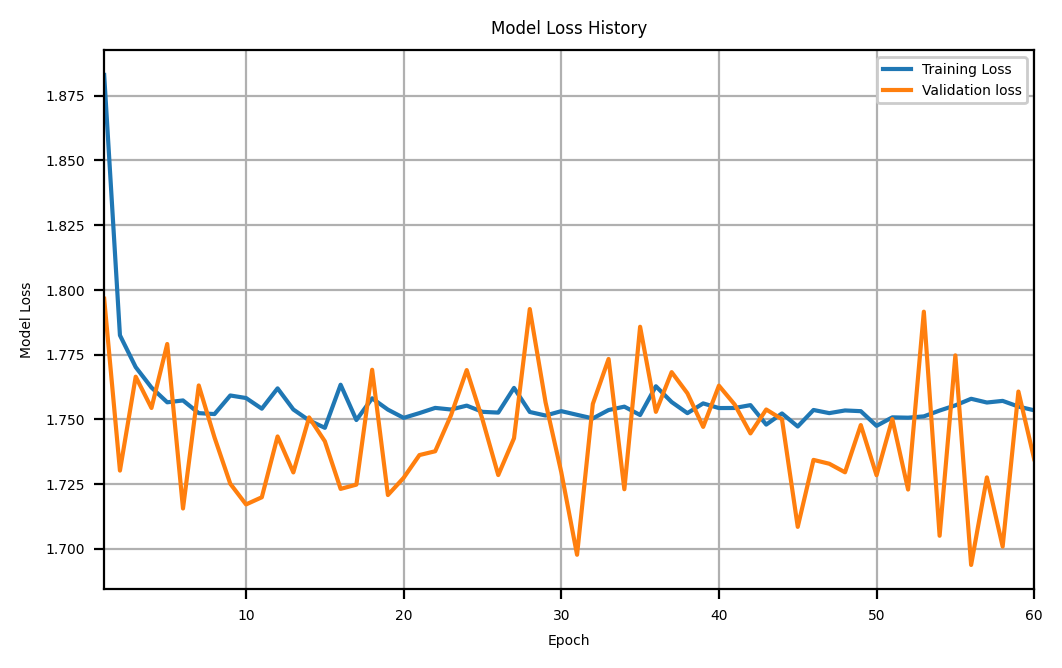

In [12]:
# create function to show model training accuracy and loss history
def model_history(history):
        # plot training history
        fig, ax = plt.subplots(figsize=(6,3.5), dpi=200)

        ax.plot(range(1,len(history['train accuracy'])+1),
                history['train accuracy'],
                label = r'Training Accuracy',
                #marker = 'o',
                markersize = 4)

        ax.plot(range(1, len(history["validation accuracy"])+1),
                history['validation accuracy'],
                label = r'Validation Accuracy',
                #marker = 'o',
                markersize = 4)

        ax.set_title("Model Accuracy History")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Model Accuracy')
        ax.set_xlim(1, len(history["train accuracy"]))
        
        ax.legend()
        ax.legend().get_frame().set_alpha(1.0)

        ax.grid(True)

        # plot loss history
        fig, ax = plt.subplots(figsize=(6,3.5), dpi=200)

        ax.plot(range(1,len(history['train loss'])+1),
                history['train loss'],
                label = r'Training Loss',
                #marker = 'o',
                markersize = 4)

        ax.plot(range(1, len(history["validation loss"])+1),
                history['validation loss'],
                label = r'Validation loss',
                #marker = 'o',
                markersize = 4)

        ax.set_title("Model Loss History")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Model Loss')
        ax.set_xlim(1, len(history["train loss"]))
        ax.legend()
        ax.legend().get_frame().set_alpha(1.0)
        
        ax.grid(True)

# plot training history using the function
model_history(trained_resnet18_based)

### Transfer Learning Model Evaluation

#### Test Accuracy

We next define the `evaluation()` function to evaluate the trained model on the `extracted_test_loader` DataLoader. Similar to our training loop, this function returns a dictionary of relevant items for analysis and further visual inspection.

In [13]:
from sklearn.metrics import accuracy_score

def evaluate(history, test_loader):
    
    model = history["model"]

    model.to(device)
    model.eval()
    softmax = nn.Softmax(dim=1).to(device)
    
    probs_list = []
    y_true = []
    
    test_loss = 0
    
    for data in tqdm(test_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_true.append(labels)

        with torch.no_grad():
            
            # forward pass and loss on model
            linear_outputs = model(inputs)
            loss = criterion(linear_outputs, labels)

        # apply softmax layer
        outputs = softmax(linear_outputs)
        
        # add loss to total
        test_loss += loss.item()
        
        # append softmax probabilities to probs_list
        for prob, label in zip(outputs, labels):
            probs_list.append(prob.cpu().tolist())
            
    
    y_true = torch.cat(y_true, dim=0).cpu()
    
    # compute total loss on test set
    test_loss /= len(test_loader)
    
    # get predicitons
    y_pred = list(np.argmax(np.asarray(probs_list), axis = 1))
    
    # report accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    print("Test Accuracy:", accuracy)
    print("Test Loss: {:.4f}".format(test_loss))
    
    # return dictionary
    evaluation = {
        "accuracy": accuracy,
        "loss": test_loss,
        "y_pred": list(y_pred),
        "y_true": list(y_true),
        "probs": list(probs_list)
    }
    
    return evaluation
        
test_results = evaluate(trained_resnet18_based, test_loader)

  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 0.3956
Test Loss: 1.7173


The transfer learning model performed with a test accuracy of 39.56%. While not successful enough for say deployment at scale, it did succeed in being a better predictor than the naive predictor accuracy of 10%.

In [14]:
total_params = sum(p.numel() for p in resnet18_based.fc.parameters())
print(f"Number of trainable parameters: {total_params}")

Number of trainable parameters: 5130


The low accuracy of this model can be attributed to the relatively small number of trainable parameters (5,130) to the size of the training data (50,000 instances). The model is unable to generalize well given the number of parameters it has at its disposal.

#### Confusion Matrix Analysis
In addition to test accuracy, a confusion matrix can be displayed to further evaluate model performance.

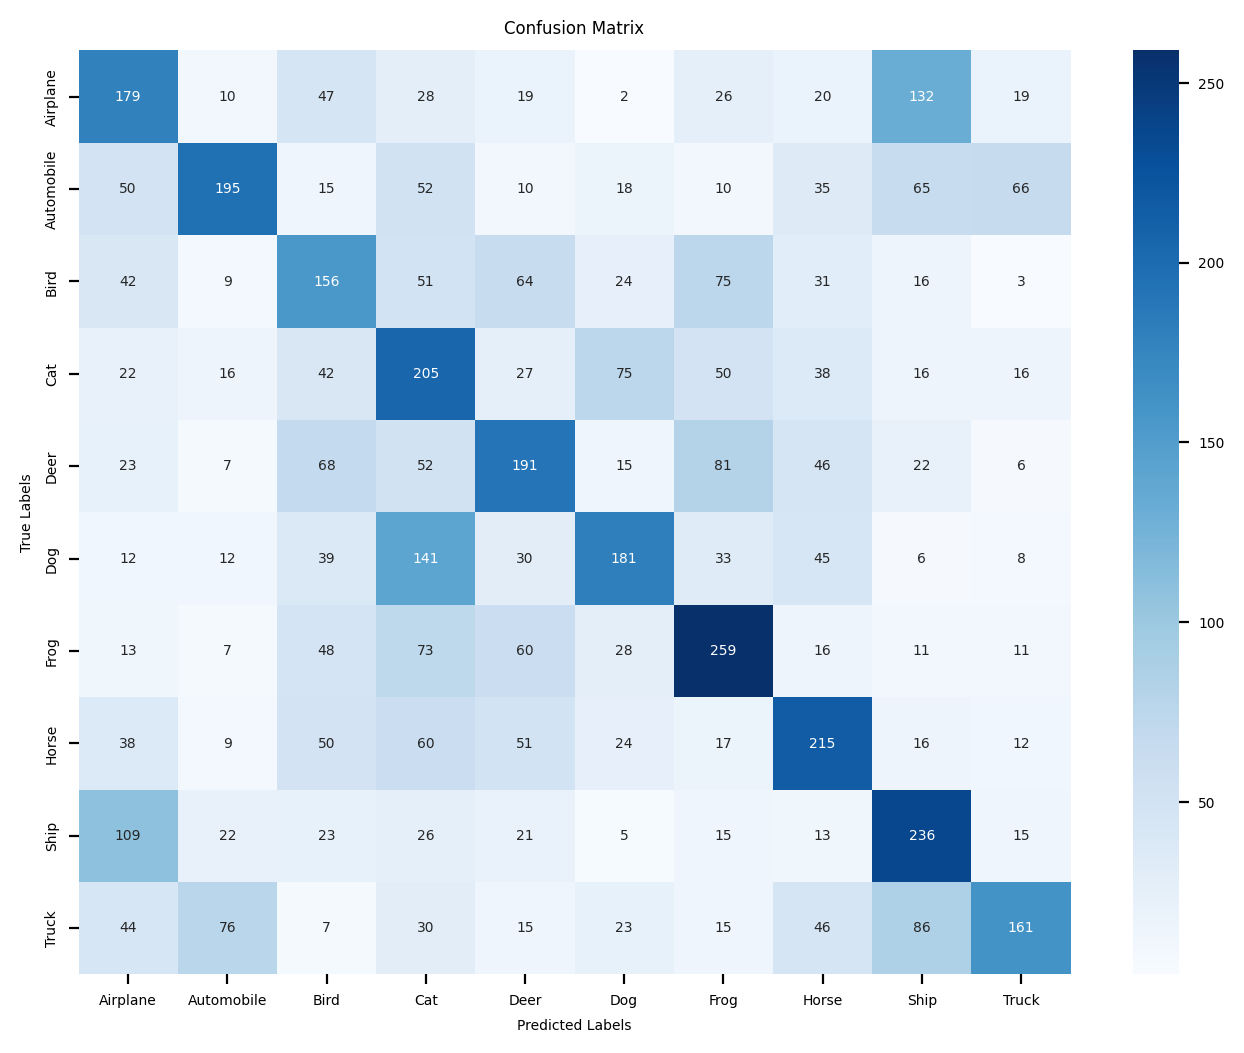

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(test_results):

    # generat confusion matrix
    cm = confusion_matrix(test_results["y_true"], test_results["y_pred"])

    plt.figure(figsize=(8, 6), dpi = 200)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=CIFAR10_labels.values(), yticklabels=CIFAR10_labels.values())
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(test_results)


The poor performance of the transfer learning model is evident in the above confusion matrix. It is noteable that there are many incorrect predictions for very visually similar object classes such as automobiles and trucks, and incorect predictions vary for object classes that correspond to animals.

#### Predictions
The results generated from the `evaluate()` function can then be manipulated with `pandas` to obtain the top correct and incorrect predictions in terms of predicted class probability.

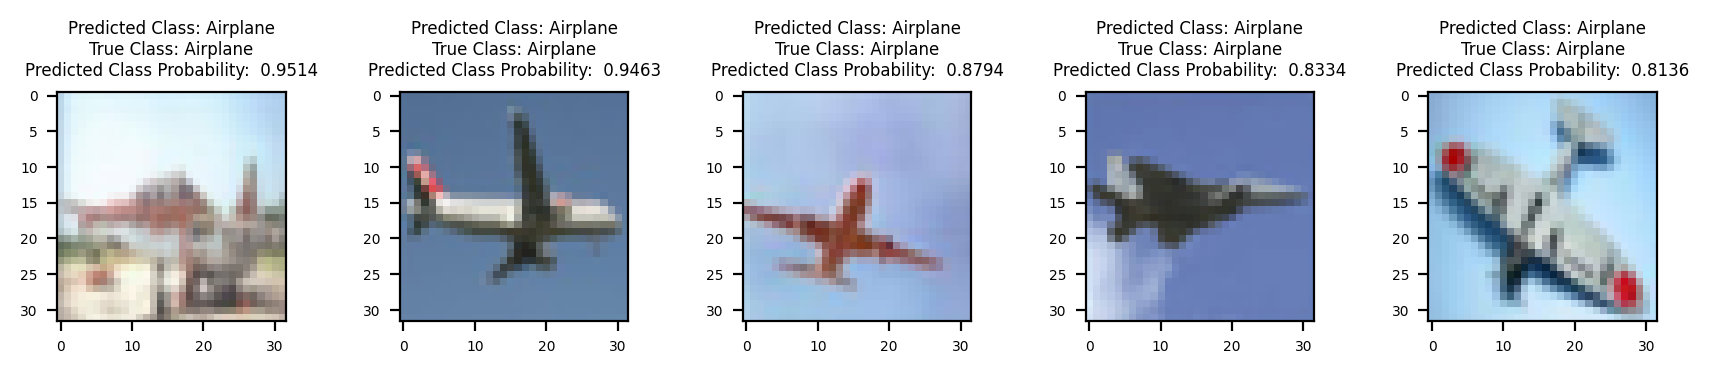

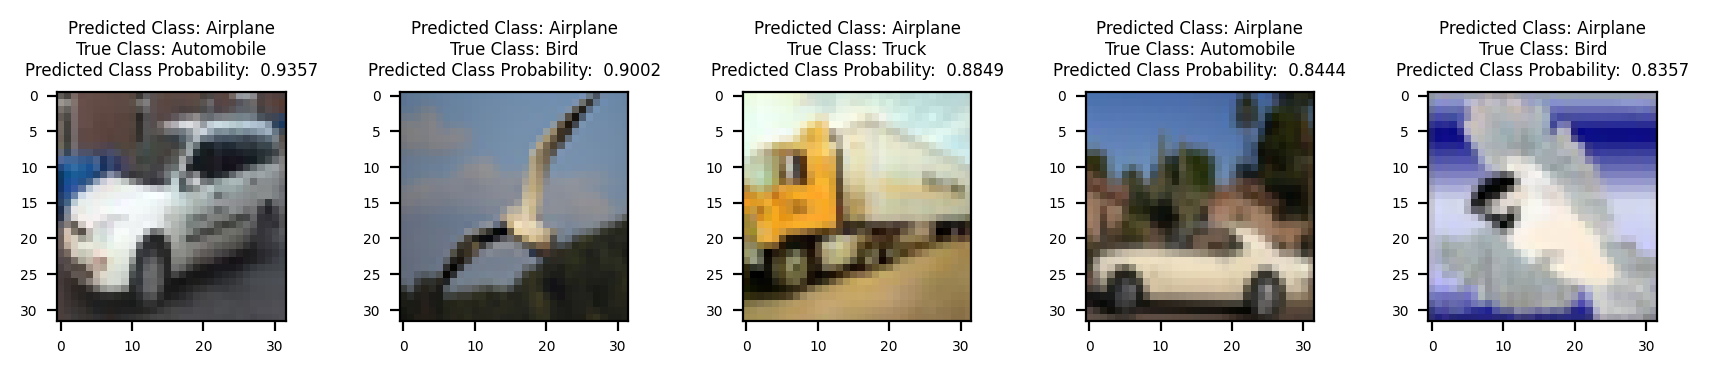

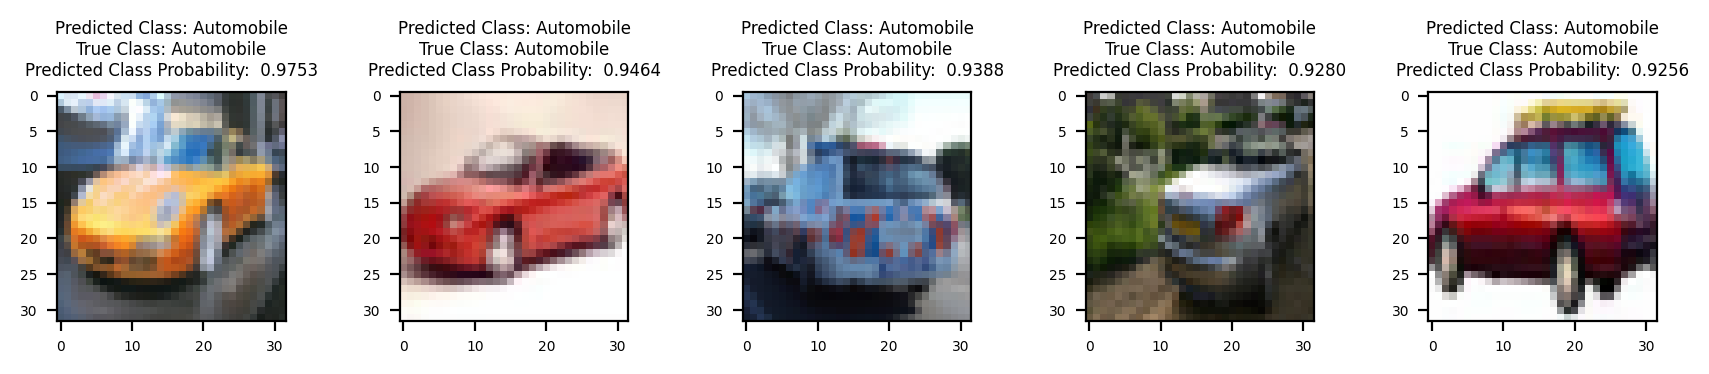

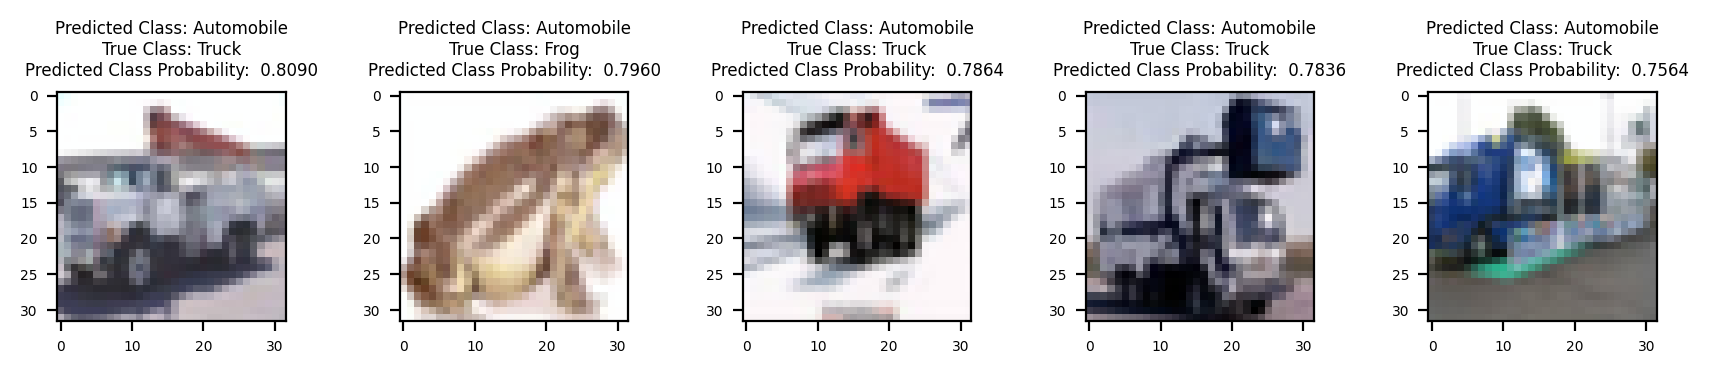

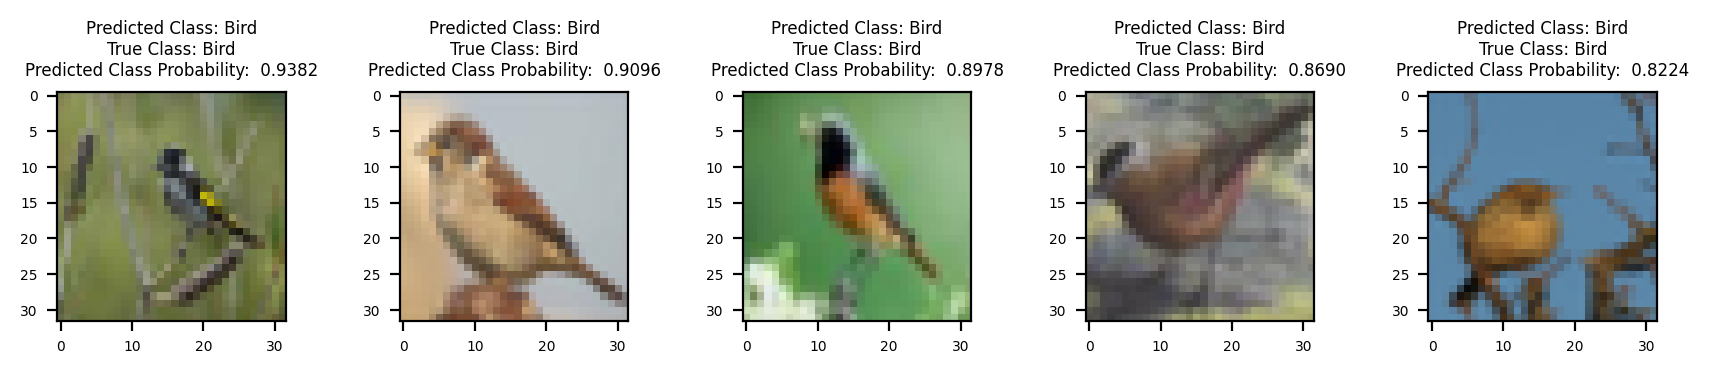

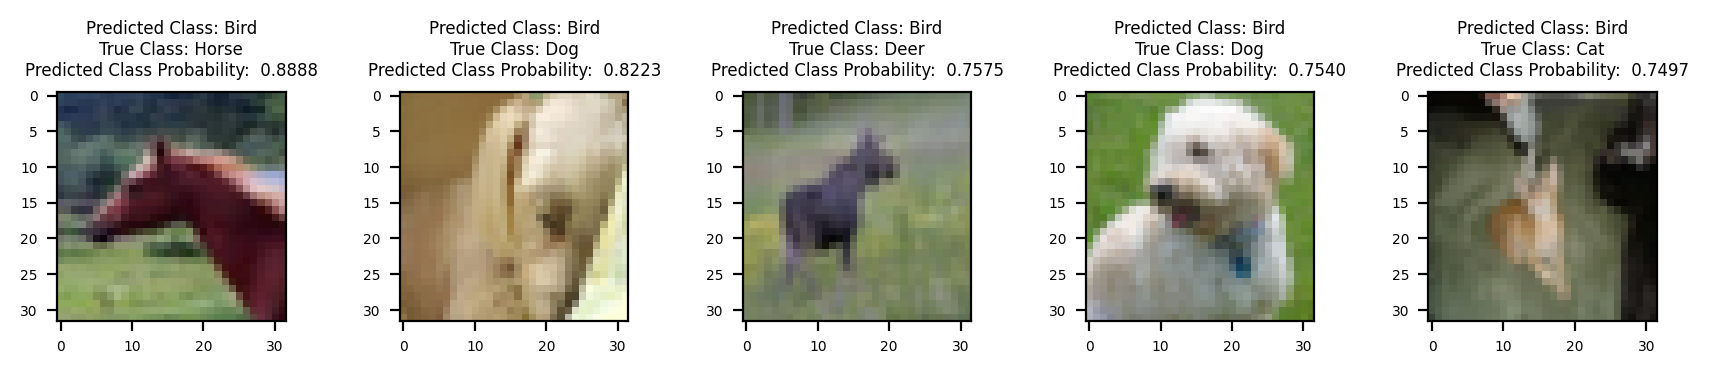

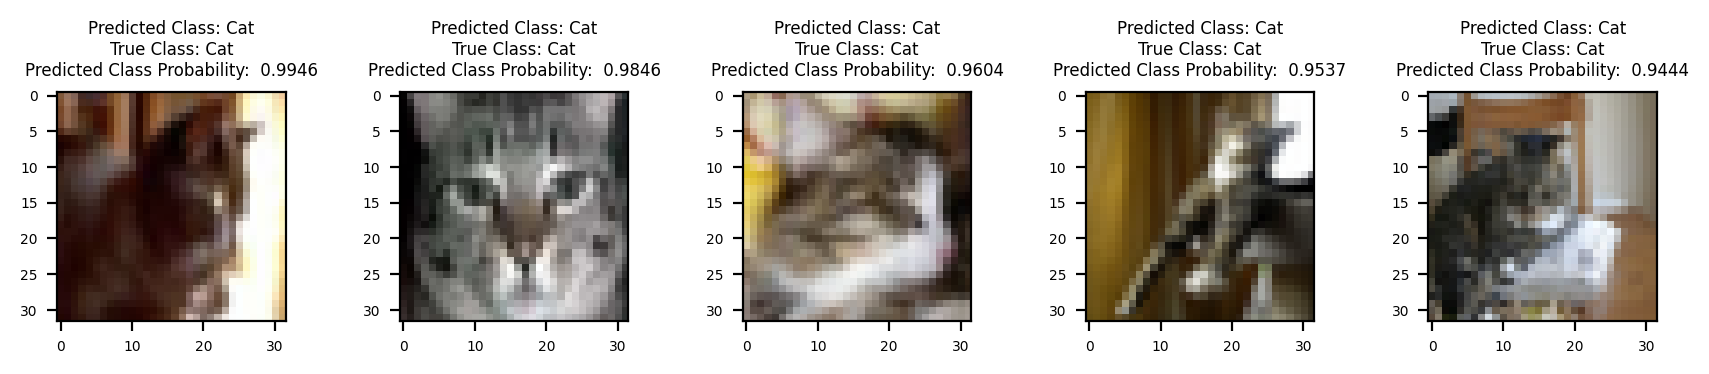

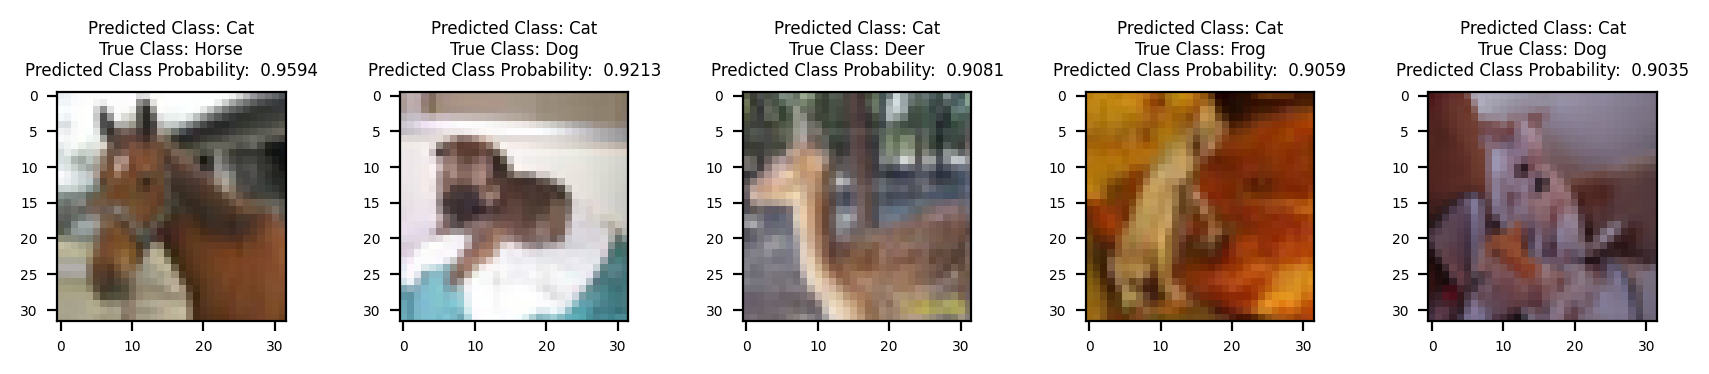

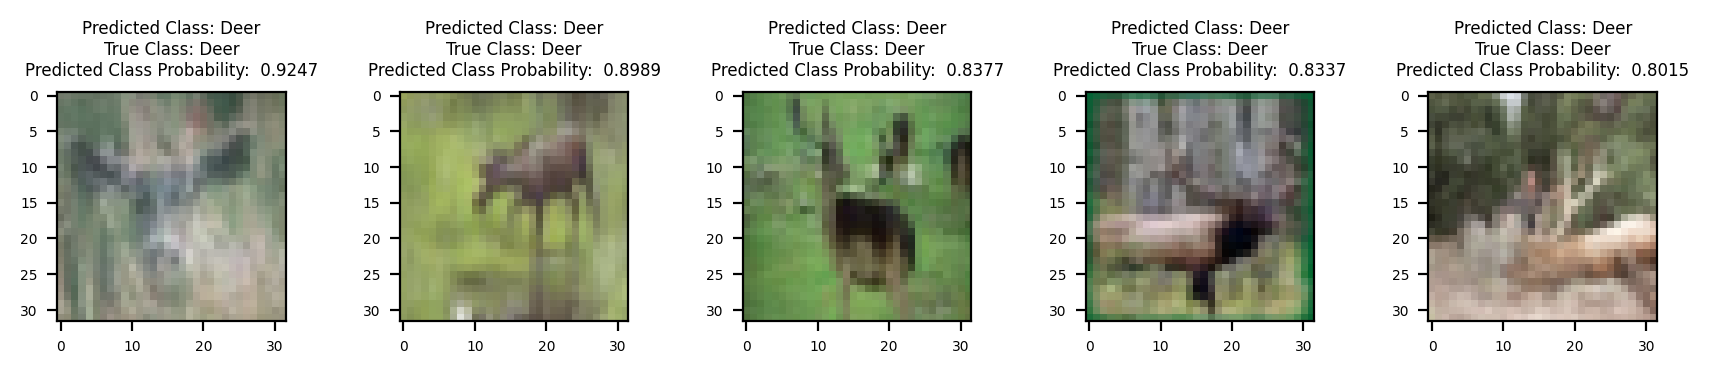

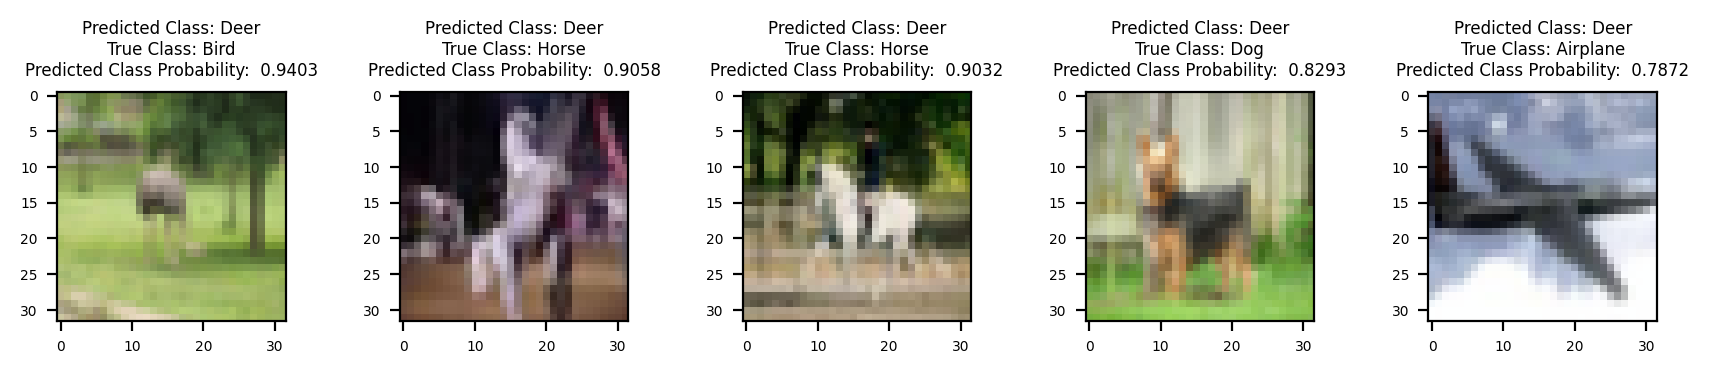

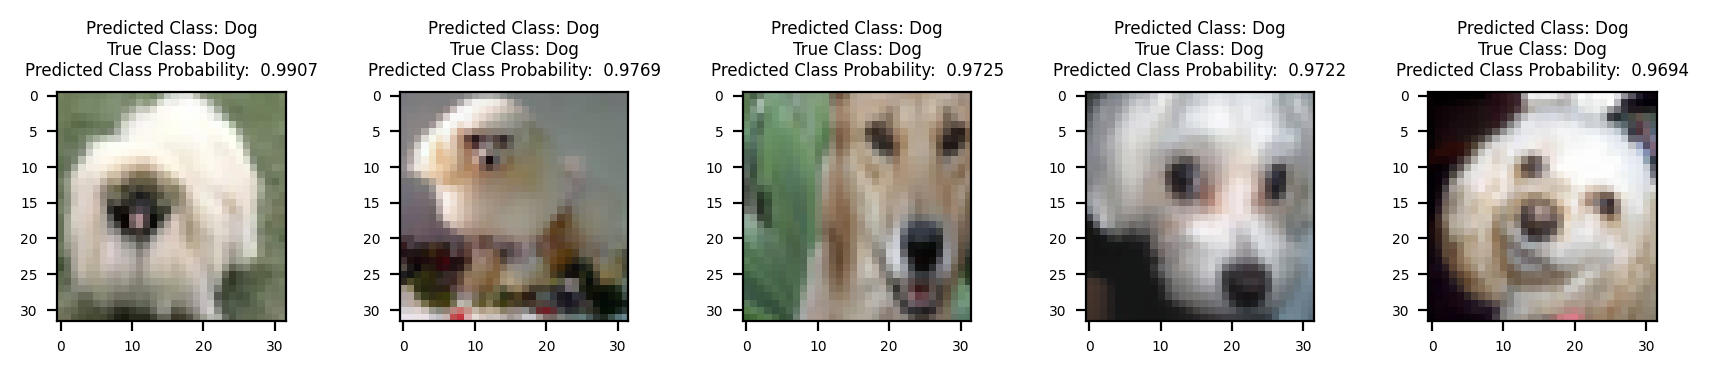

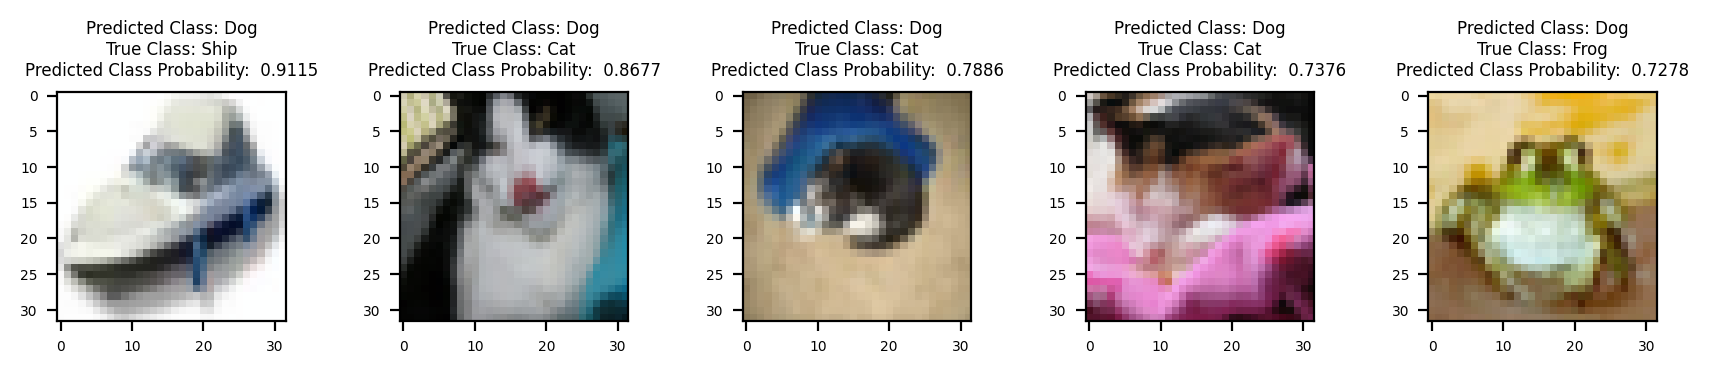

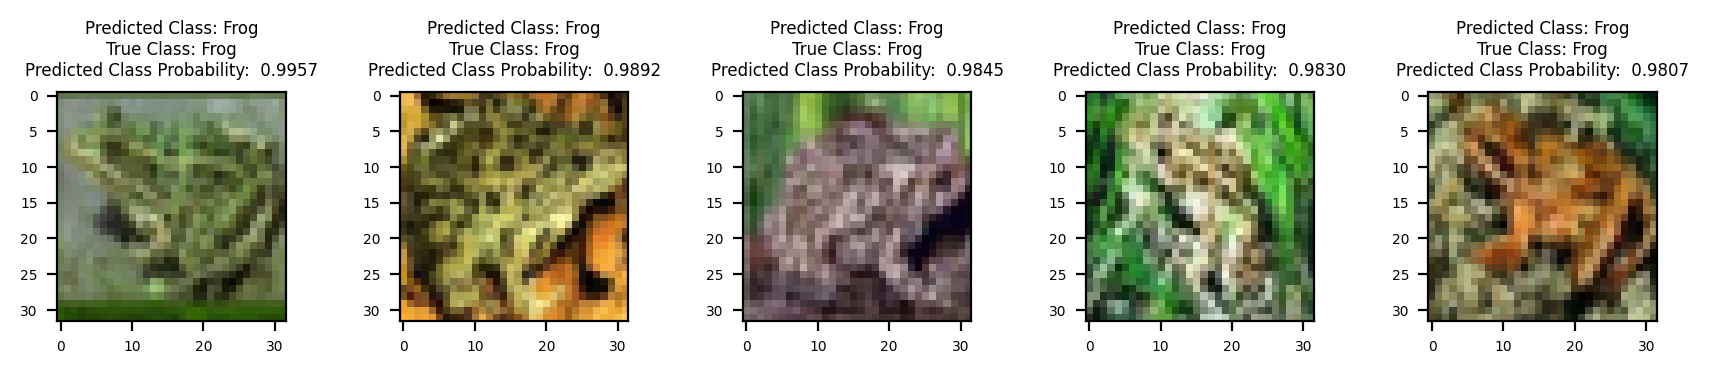

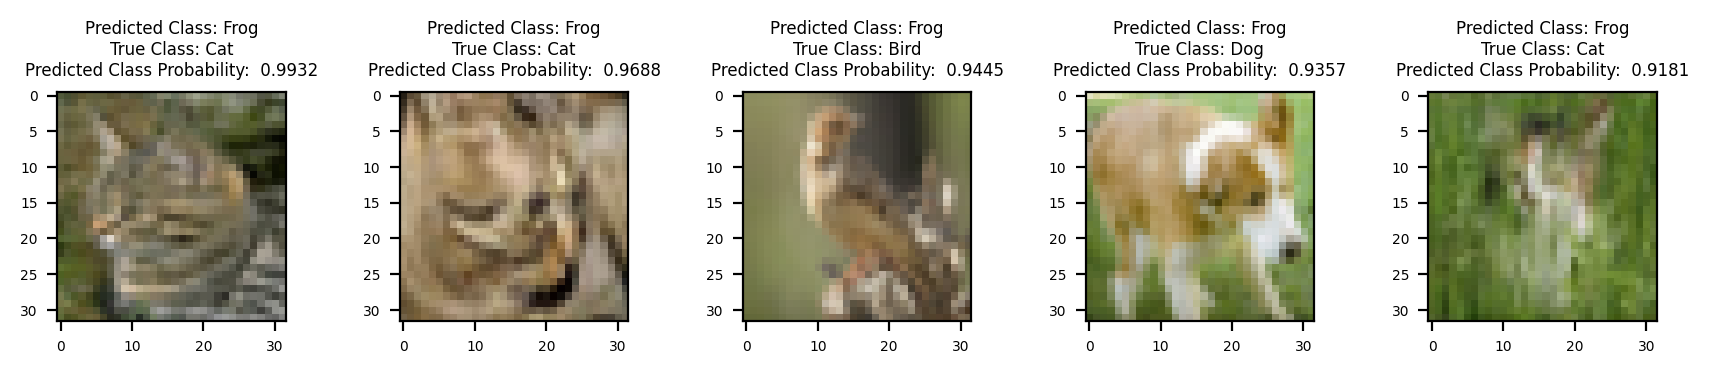

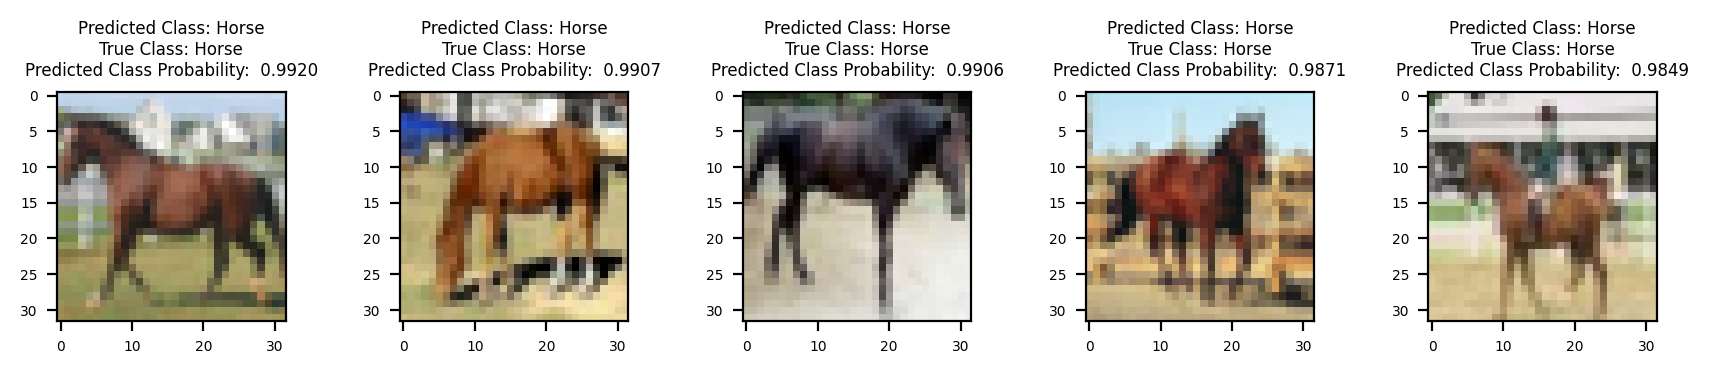

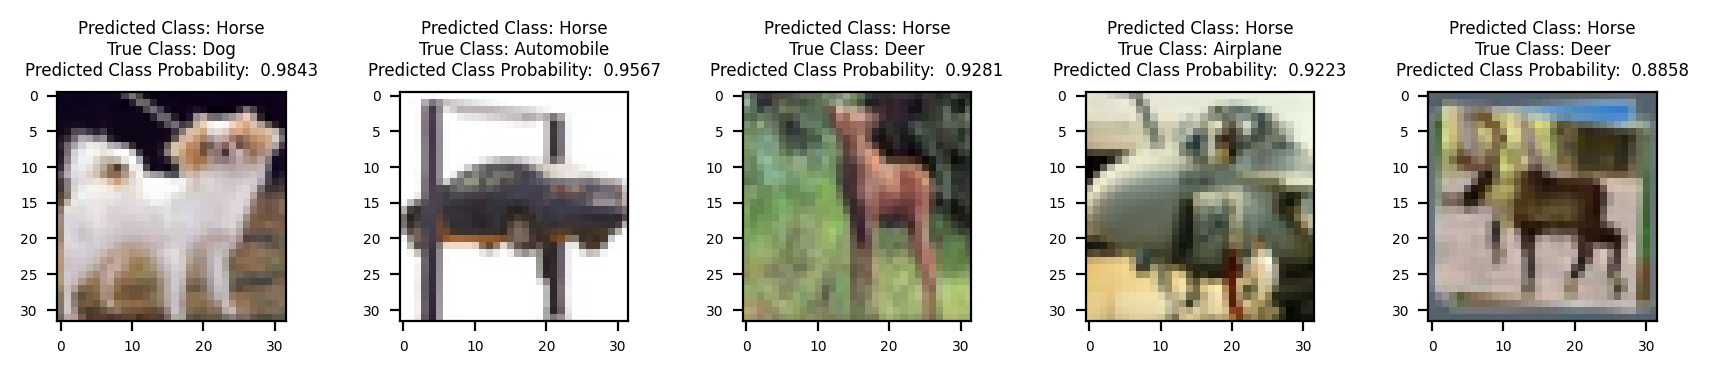

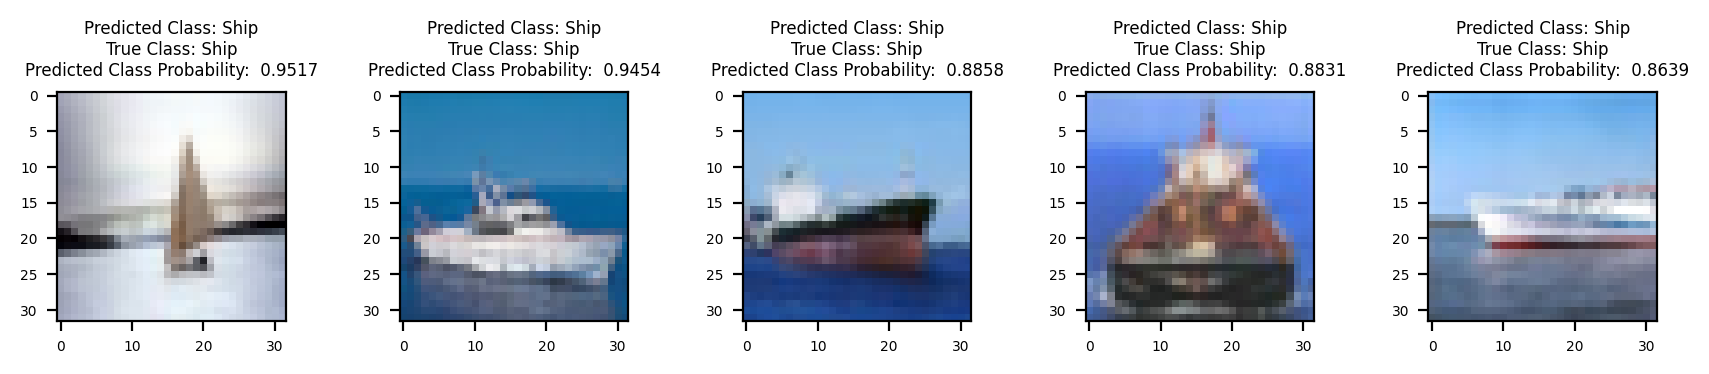

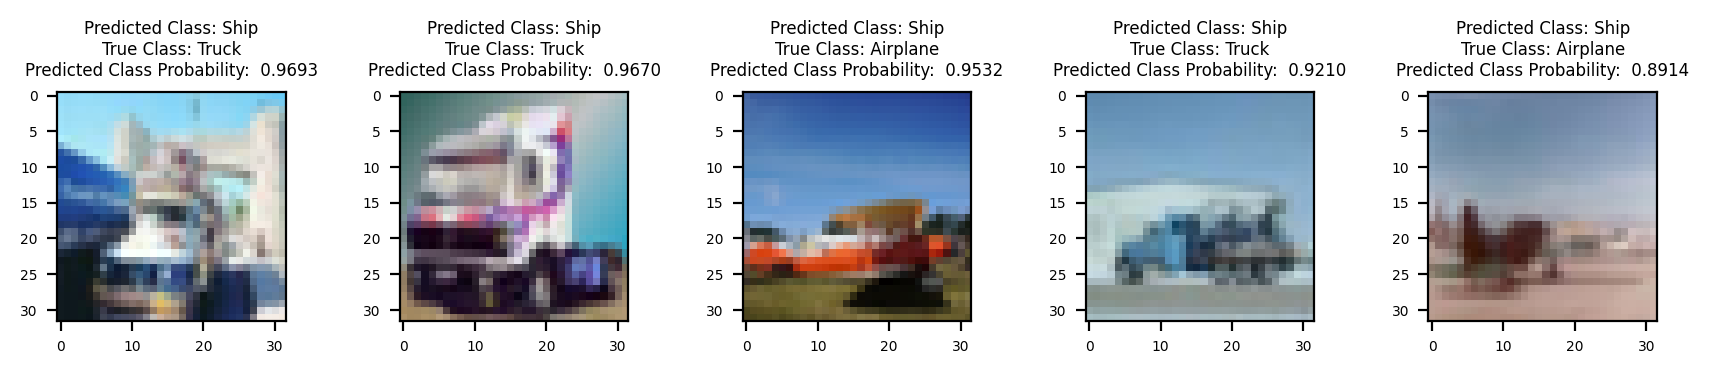

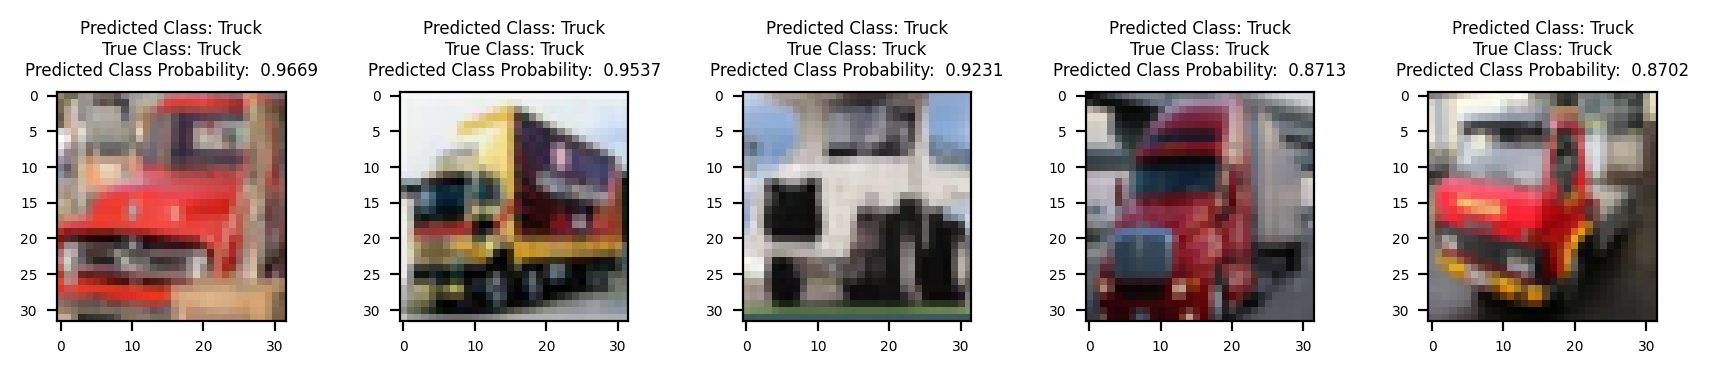

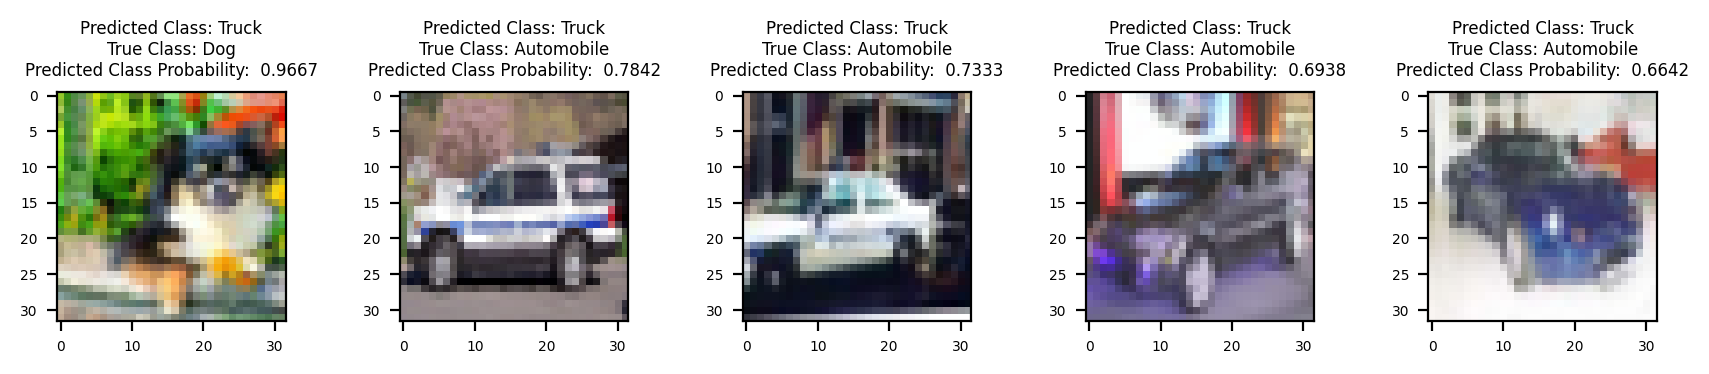

In [16]:
import pandas as pd

def prediction_results(test_results: dict = test_results, test_set = test_set):
    
    # create dataframe from test results for data manipulation
    df = pd.DataFrame(test_results, columns = test_results.keys()).drop(["accuracy", "loss"], axis=1).reset_index()

    # add predicted and true labels to the dataframe
    df["pred_class"] = df["y_pred"].apply(
        lambda x: CIFAR10_labels[int(x)]
    )

    df["true_class"] = df["y_true"].apply(
        lambda x: CIFAR10_labels[int(x)]
    )

    # obtain predicted class probability
    df["pred_prob"] = df["probs"].apply(
        lambda x: np.max(x)
    )
    
    # create list of dataframes of top best and worst predictions
    best_predictions = []
    worst_predictions = []
    
    for label in list(CIFAR10_labels.keys()):
        
        # create dataframes of top 5 best and worst predictions
        best_prediction = df.query(str(label)+" == y_true == y_pred").sort_values(by="pred_prob", ascending=False).head(5)
        worst_prediction = df.query(str(label)+" == y_pred != y_true").sort_values(by="pred_prob", ascending=False).head(5)
        
        # append to list of predictions
        best_predictions.append(best_prediction)
        worst_predictions.append(worst_prediction)
    
    # define functino for plotting
    def plotter(df, title):
        fig = plt.figure(figsize=(10,2), dpi = 200)

        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.5, hspace=0.4)

        for i, (idx, row) in enumerate(df.iterrows()):

            ax = fig.add_subplot(1, 5, i+1)
            ax.set_title(
                f"Predicted Class: {row[4]}\n"+
                f"True Class: {row[5]}\n"+
                f"Predicted Class Probability: {row[6]: .4f}"
            )
            
            ## print(CIFAR10_labels[test_set[idx][1]])
            
            img = test_set[idx][0].numpy().transpose((1, 2, 0))
            img = std * img + mean
            img = np.clip(img, 0, 1.)
            img = test_set[idx][0].numpy().transpose((1, 2, 0))
            img = std * img + mean
            img = np.clip(img, 0, 1.)
            plt.imshow(img)
            
    for best_pred, worst_pred in zip(best_predictions, worst_predictions):
        plotter(best_pred, "Correct")
        plotter(worst_pred, "Incorrect")

prediction_results(test_results, test_set)

### Fine tuning model

Similar to the transfer learning model, a `resnet18` model is created and modified to predict 10 labels. However, all parameters are subject to gradient update.

In order to evaluate this models performance against the transfer learning model, we maintain previoulsy selected parameters.

In [17]:
# create transfer learning model
resnet18_tuned = resnet18(weights=ResNet18_Weights.DEFAULT)

# replace last fully connected layer
resnet18_tuned.fc = nn.Linear(num_ftrs, 10)

resnet18_tuned.to(device)

# criterion loss function
criterion = nn.CrossEntropyLoss() # this variable is defined once and we don't change it here

# select optimizer for training
optimizer = optim.Adam(resnet18_tuned.parameters(), lr=1e-3)

### Training

In [18]:
trained_resnet18_tuned = train_model(resnet18_tuned, criterion, optimizer, train_loader, val_loader, num_epochs=30)

Epoch 1/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.2051	Train Accuracy: 0.5851
Validation Loss: 0.8813	Validation Accuracy: 0.6919

Epoch 2/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.9208	Train Accuracy: 0.6842
Validation Loss: 0.7464	Validation Accuracy: 0.7460

Epoch 3/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.8228	Train Accuracy: 0.7175
Validation Loss: 0.7264	Validation Accuracy: 0.7496

Epoch 4/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.7656	Train Accuracy: 0.7372
Validation Loss: 0.6844	Validation Accuracy: 0.7708

Epoch 5/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.7019	Train Accuracy: 0.7593
Validation Loss: 0.6208	Validation Accuracy: 0.7882

Epoch 6/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.6640	Train Accuracy: 0.7717
Validation Loss: 0.5834	Validation Accuracy: 0.7998

Epoch 7/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.6367	Train Accuracy: 0.7810
Validation Loss: 0.5640	Validation Accuracy: 0.8022

Epoch 8/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.6337	Train Accuracy: 0.7815
Validation Loss: 0.5806	Validation Accuracy: 0.8050

Epoch 9/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.5796	Train Accuracy: 0.7995
Validation Loss: 0.5691	Validation Accuracy: 0.8004

Epoch 10/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.5480	Train Accuracy: 0.8099
Validation Loss: 0.5468	Validation Accuracy: 0.8139

Epoch 11/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.5250	Train Accuracy: 0.8191
Validation Loss: 0.5632	Validation Accuracy: 0.8123

Epoch 12/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.5087	Train Accuracy: 0.8242
Validation Loss: 0.5159	Validation Accuracy: 0.8216

Epoch 13/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.4876	Train Accuracy: 0.8305
Validation Loss: 0.5457	Validation Accuracy: 0.8186

Epoch 14/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.5068	Train Accuracy: 0.8243
Validation Loss: 0.5036	Validation Accuracy: 0.8327

Epoch 15/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.4654	Train Accuracy: 0.8381
Validation Loss: 0.5892	Validation Accuracy: 0.8040

Epoch 16/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.4390	Train Accuracy: 0.8471
Validation Loss: 0.5129	Validation Accuracy: 0.8347

Epoch 17/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.4307	Train Accuracy: 0.8507
Validation Loss: 0.4987	Validation Accuracy: 0.8313

Epoch 18/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.4172	Train Accuracy: 0.8551
Validation Loss: 0.5293	Validation Accuracy: 0.8277

Epoch 19/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.4096	Train Accuracy: 0.8569
Validation Loss: 0.5495	Validation Accuracy: 0.8182

Epoch 20/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.4040	Train Accuracy: 0.8576
Validation Loss: 0.9341	Validation Accuracy: 0.8190

Epoch 21/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.3751	Train Accuracy: 0.8688
Validation Loss: 0.5847	Validation Accuracy: 0.8299

Epoch 22/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.3663	Train Accuracy: 0.8714
Validation Loss: 0.5820	Validation Accuracy: 0.8339

Epoch 23/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.3541	Train Accuracy: 0.8770
Validation Loss: 0.5112	Validation Accuracy: 0.8408

Epoch 24/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.3446	Train Accuracy: 0.8794
Validation Loss: 0.5205	Validation Accuracy: 0.8441

Epoch 25/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.3314	Train Accuracy: 0.8832
Validation Loss: 0.5408	Validation Accuracy: 0.8392

Epoch 26/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.3597	Train Accuracy: 0.8758
Validation Loss: 0.6009	Validation Accuracy: 0.8329

Epoch 27/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.3238	Train Accuracy: 0.8860
Validation Loss: 0.5169	Validation Accuracy: 0.8406

Epoch 28/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.2993	Train Accuracy: 0.8939
Validation Loss: 0.5644	Validation Accuracy: 0.8333

Epoch 29/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.2987	Train Accuracy: 0.8943
Validation Loss: 0.5477	Validation Accuracy: 0.8445

Epoch 30/30


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.2926	Train Accuracy: 0.8969
Validation Loss: 0.5395	Validation Accuracy: 0.8451



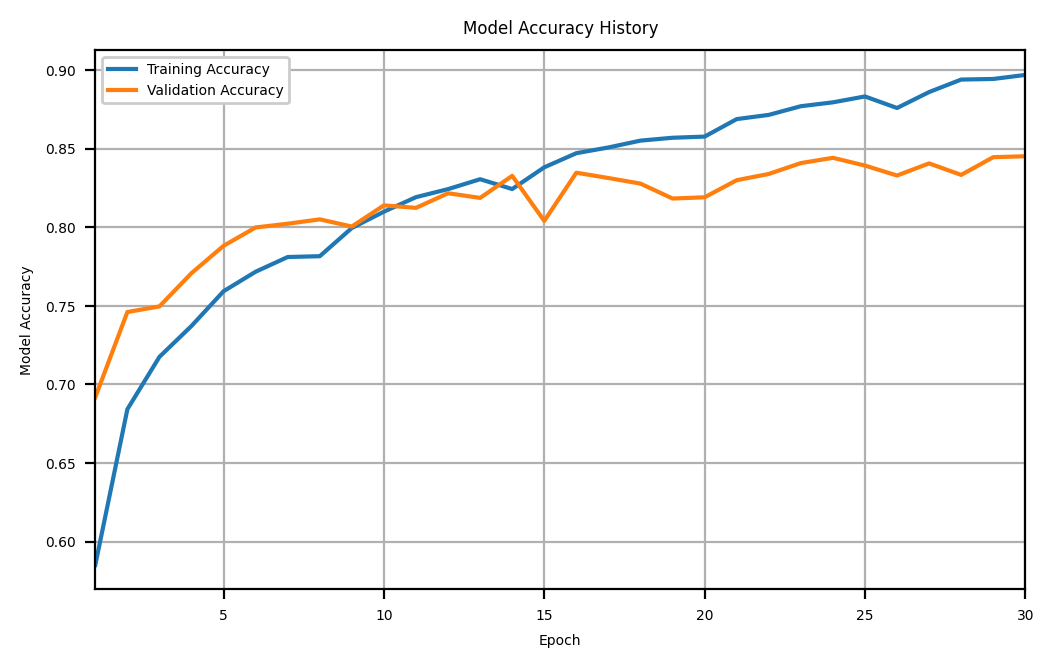

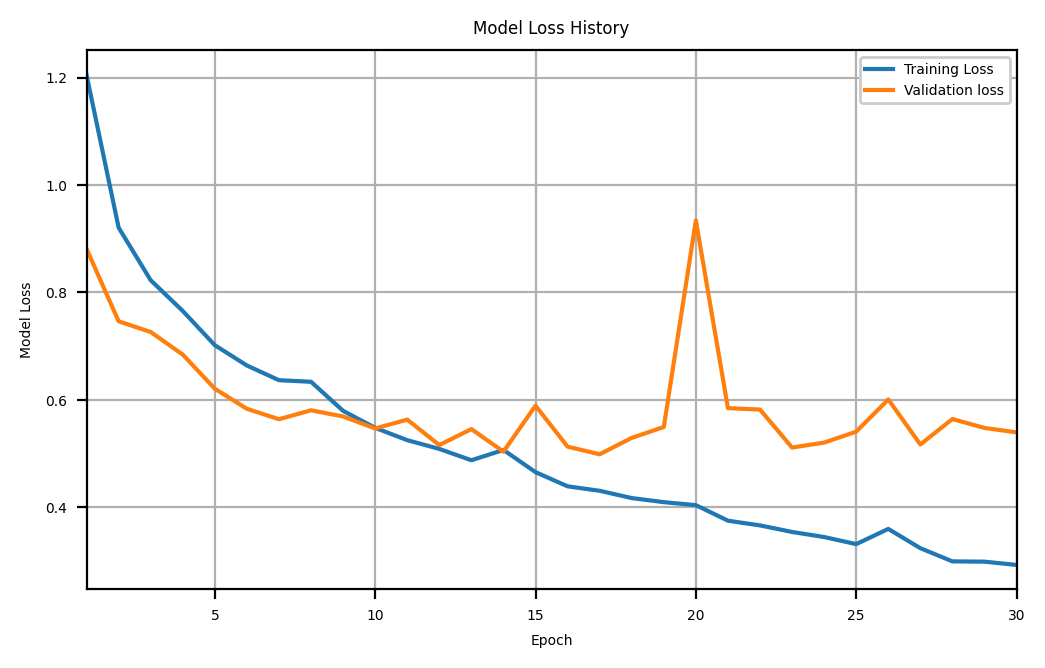

In [20]:
model_history(trained_resnet18_tuned)

### Fine Tuned Model Evaluation

#### Test Accuracy

In [21]:
test_results = evaluate(trained_resnet18_tuned, test_loader)

total_params = sum(p.numel() for p in resnet18_tuned.parameters())
print(f"\nNumber of trainable parameters: {total_params}")

  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 0.826
Test Loss: 0.5730

Number of trainable parameters: 11181642


The fine tuned model performed much better than the transfer learning model in terms of test accuracy.

#### Confusion Matrix Analysis

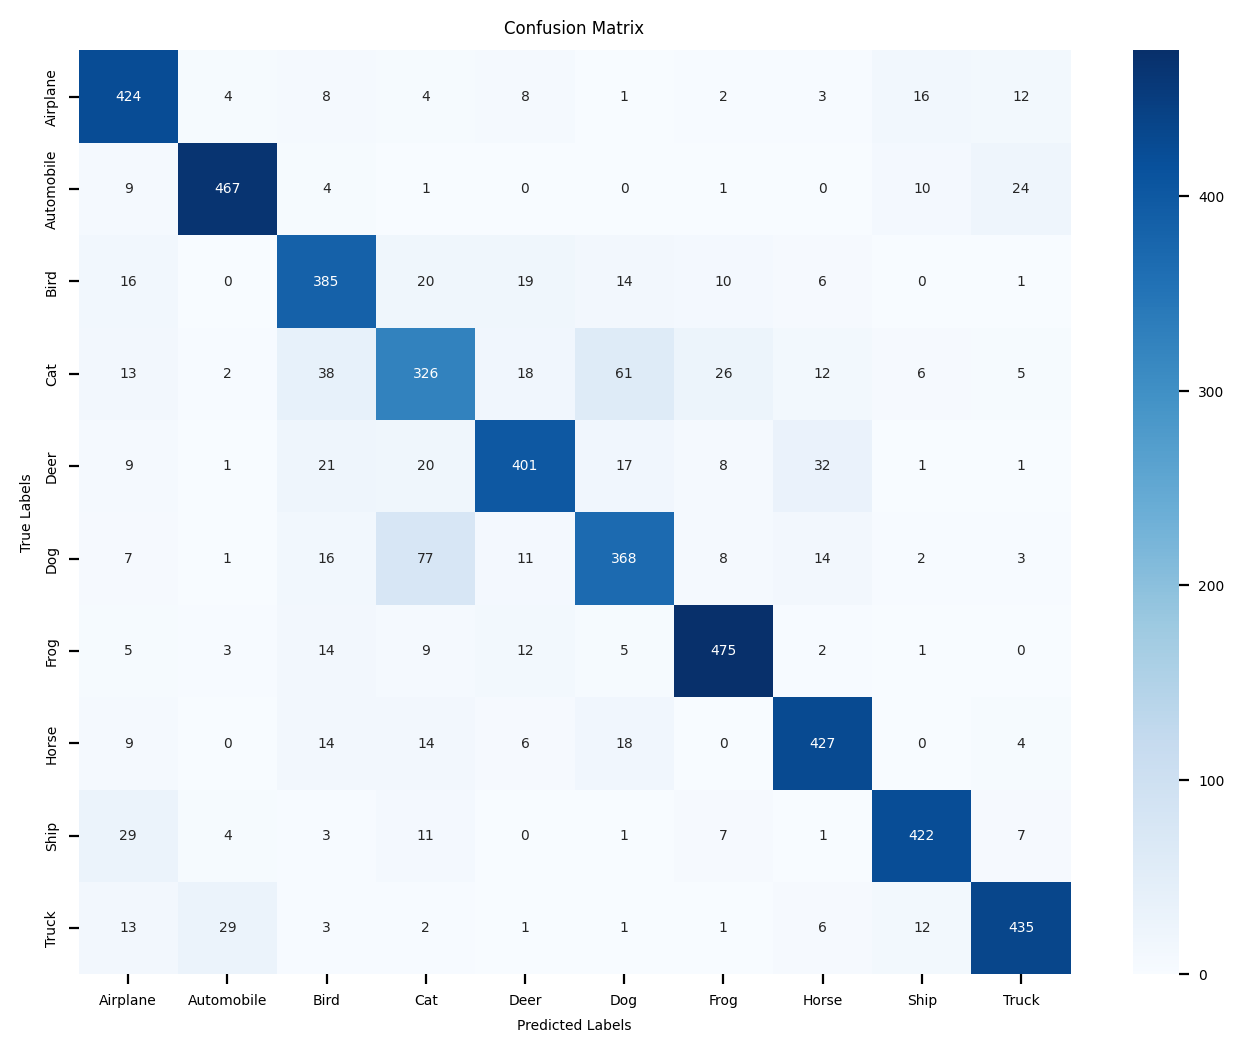

In [22]:
plot_confusion_matrix(test_results)

The confusion matrix for the fine tuned model exhibits resounding gains in accuracy from the transfer learning model, with minimial misclassifications to the object classes corresponding to vehicles. Noticeable misclassifications occurred in the dog and cat object class, which makes sense due to both animals sharing similar physical properties.

#### Predictions

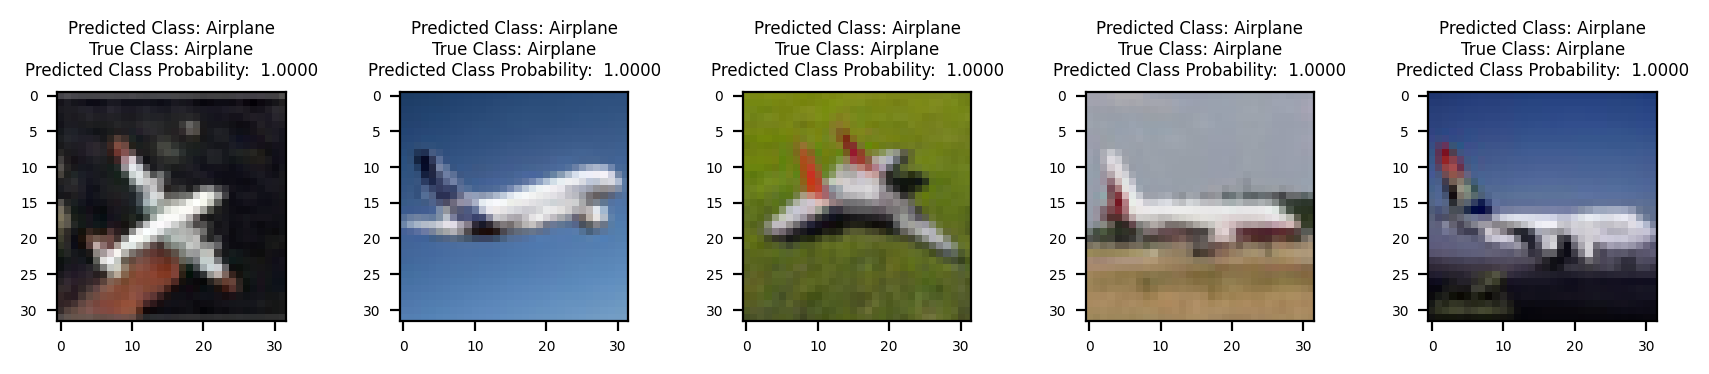

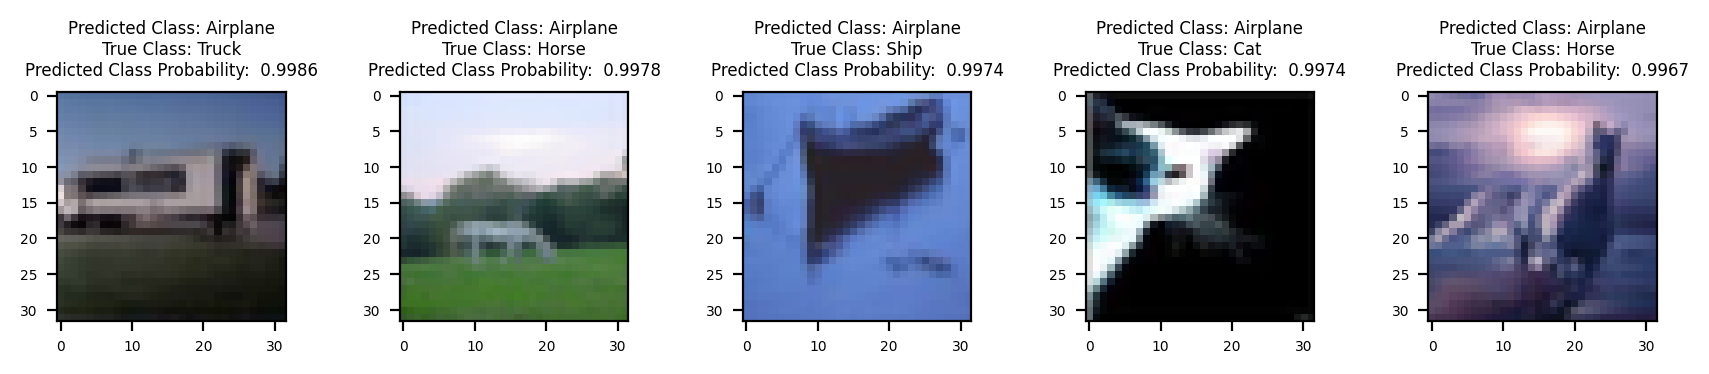

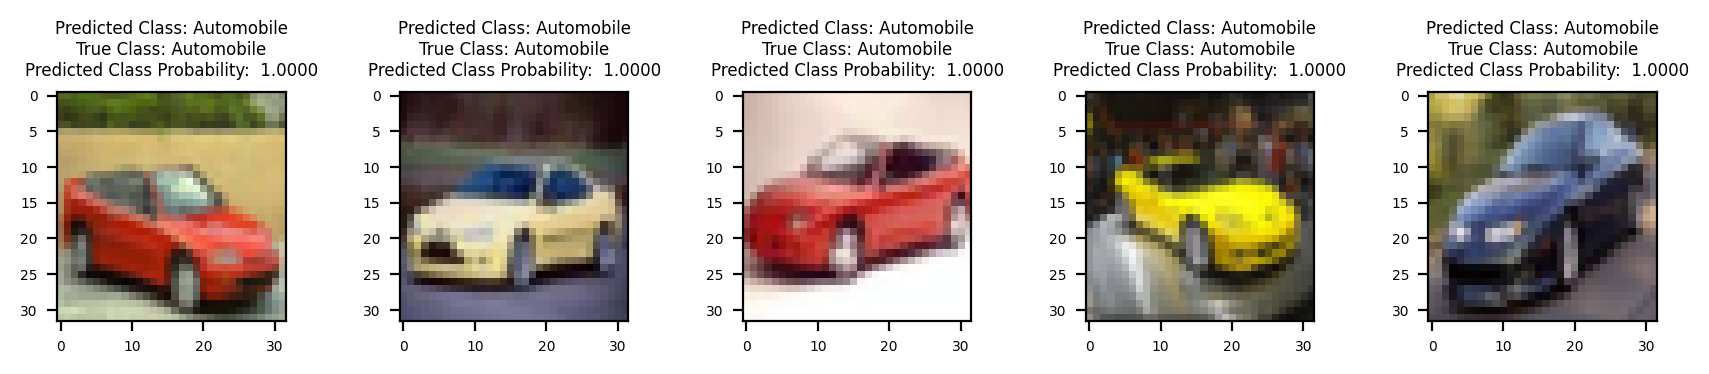

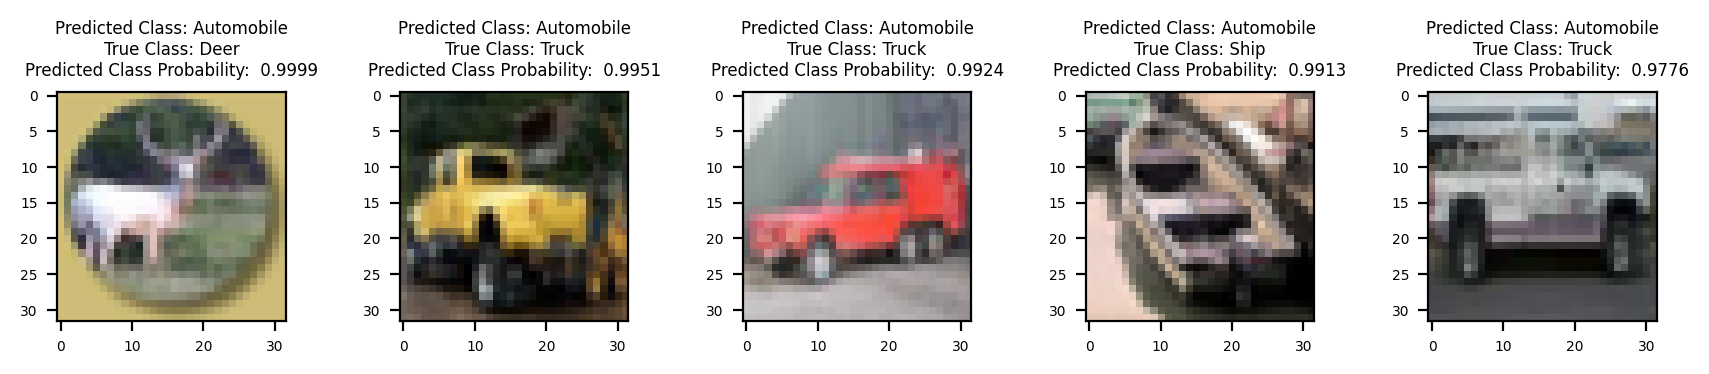

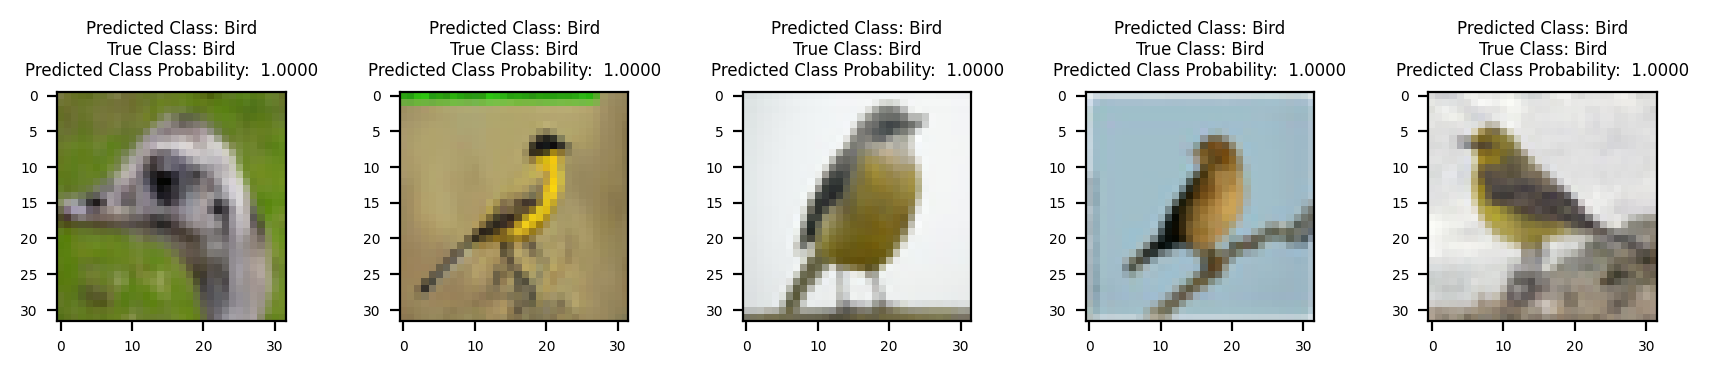

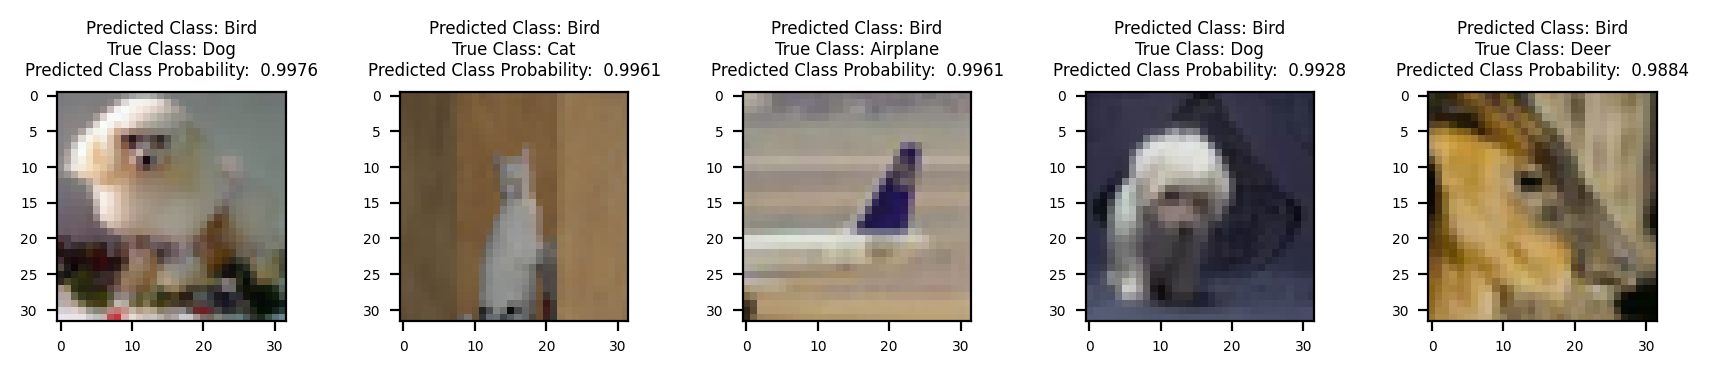

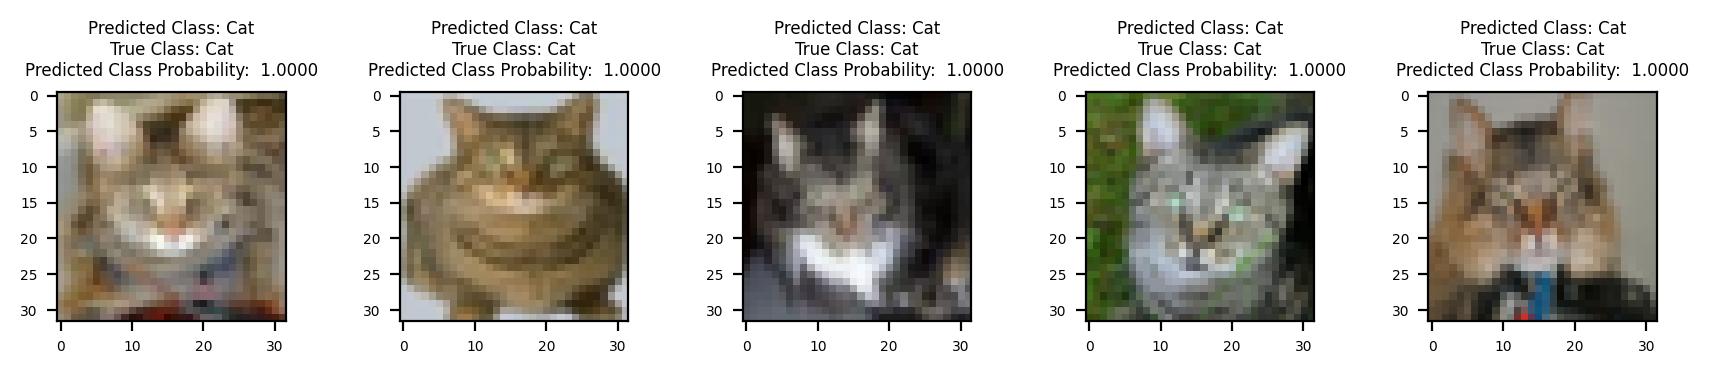

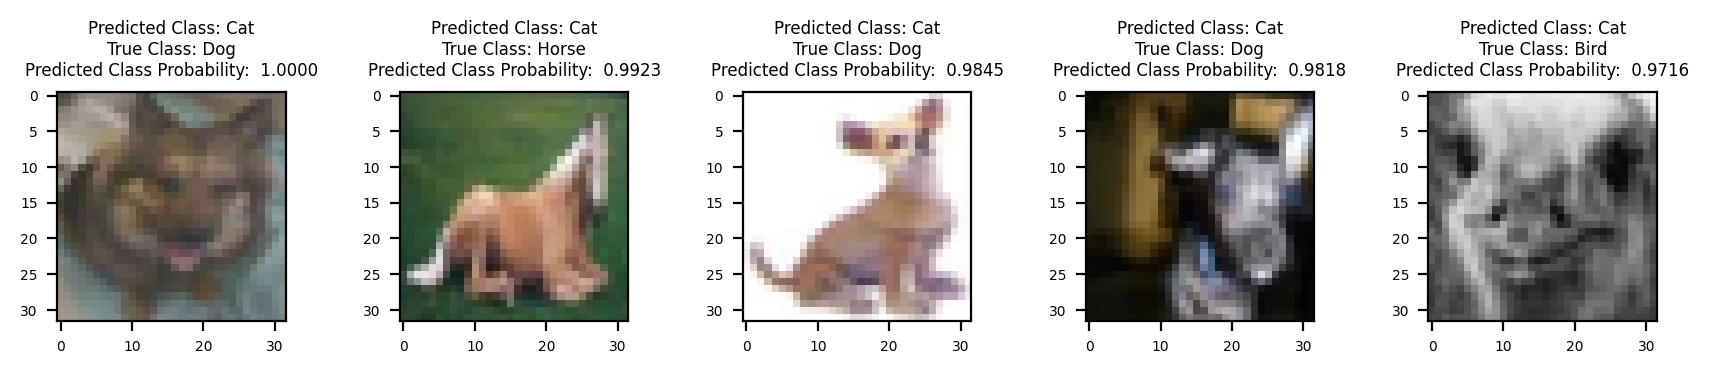

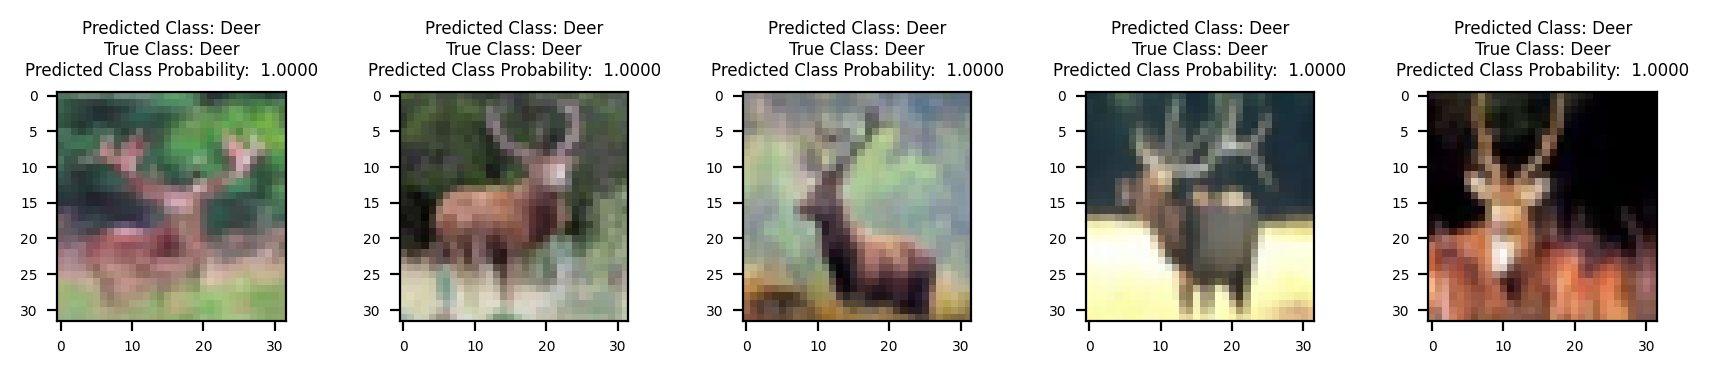

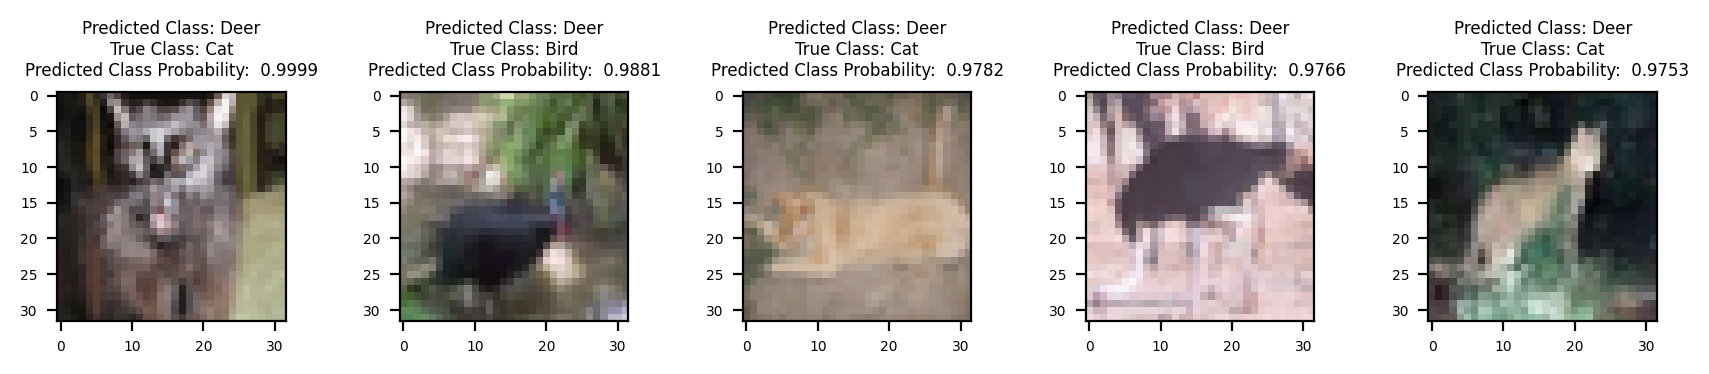

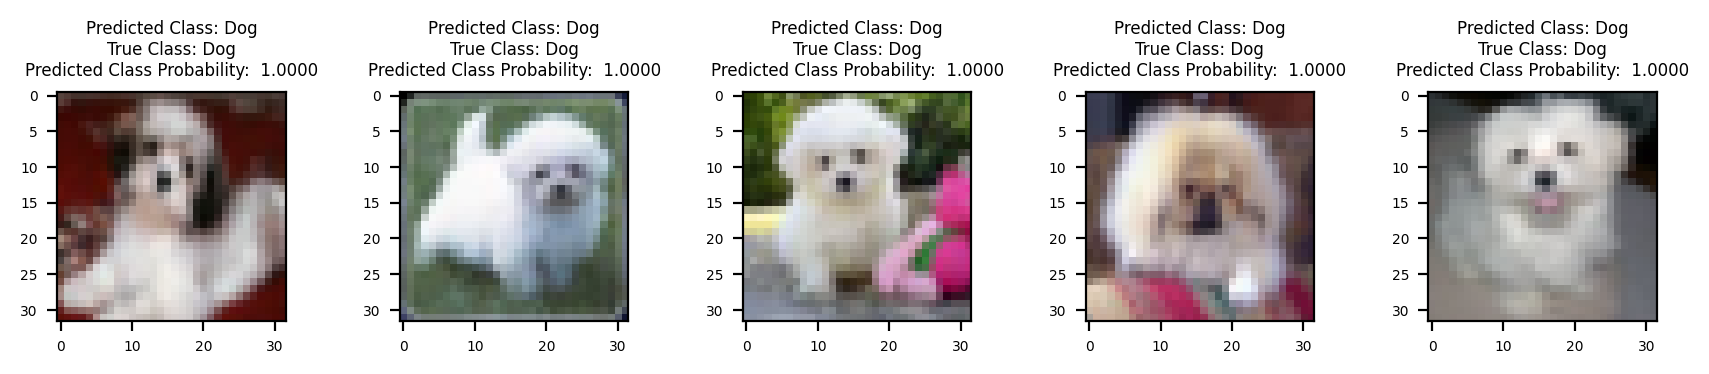

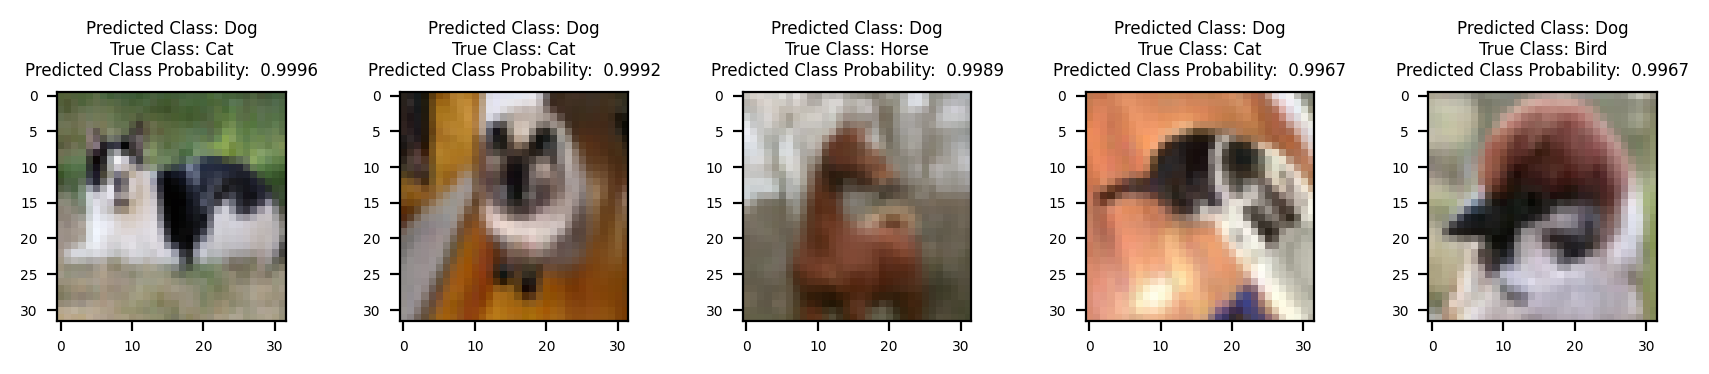

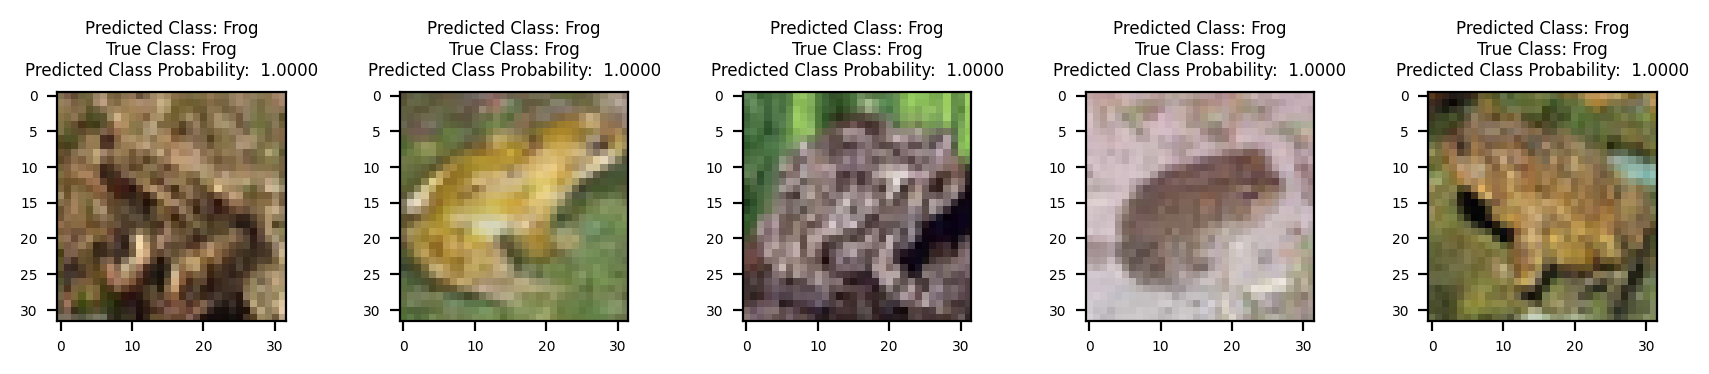

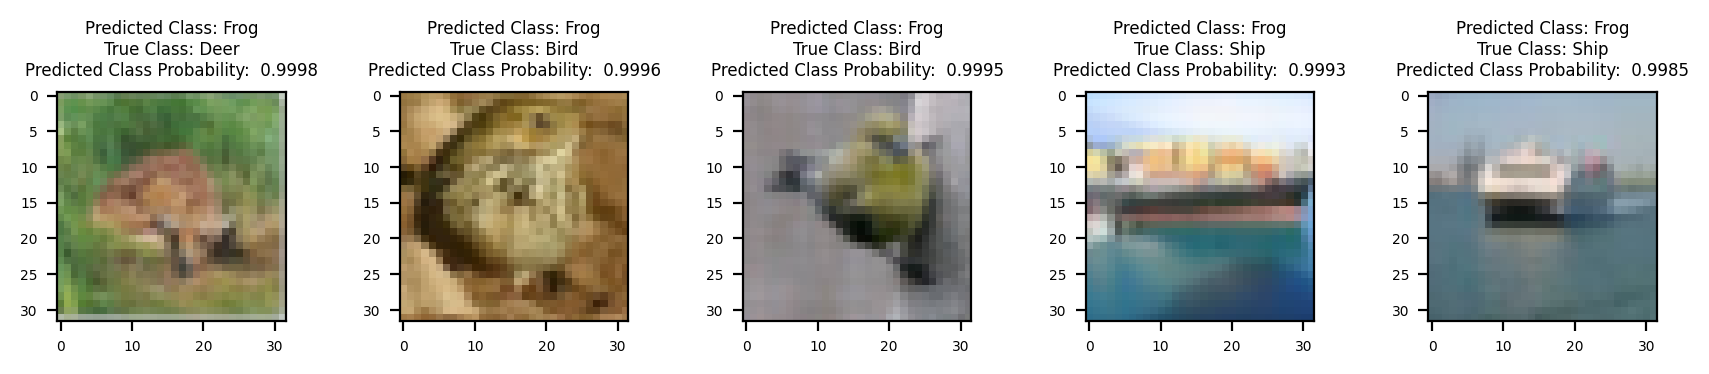

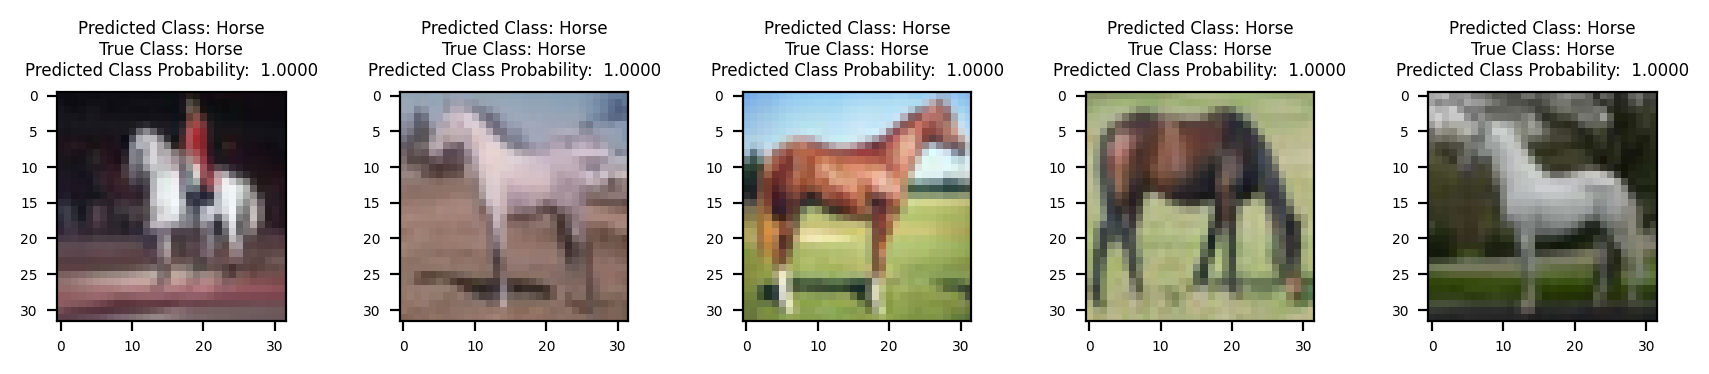

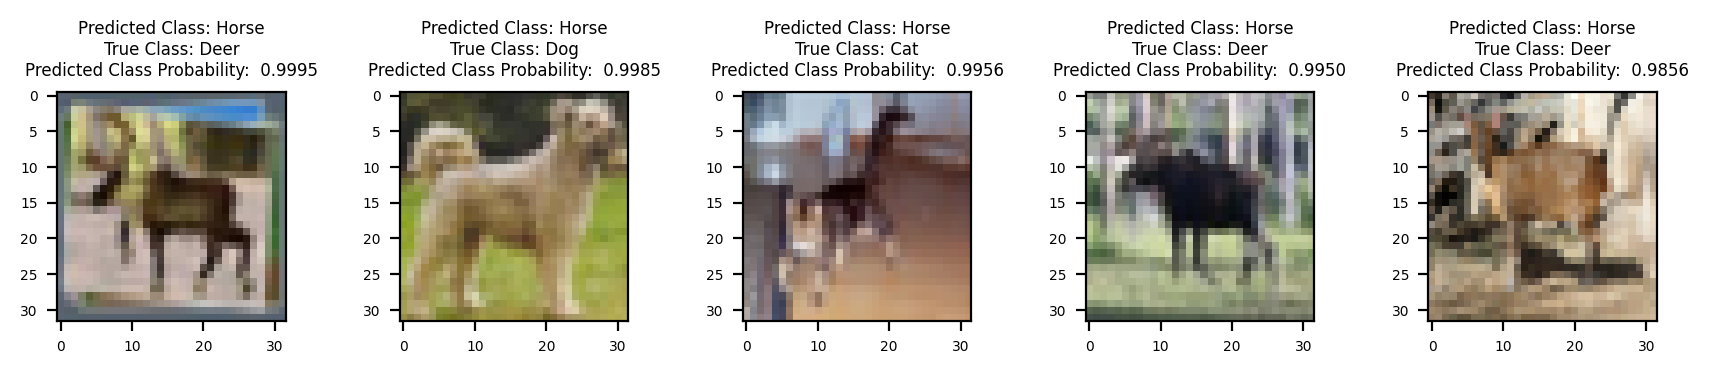

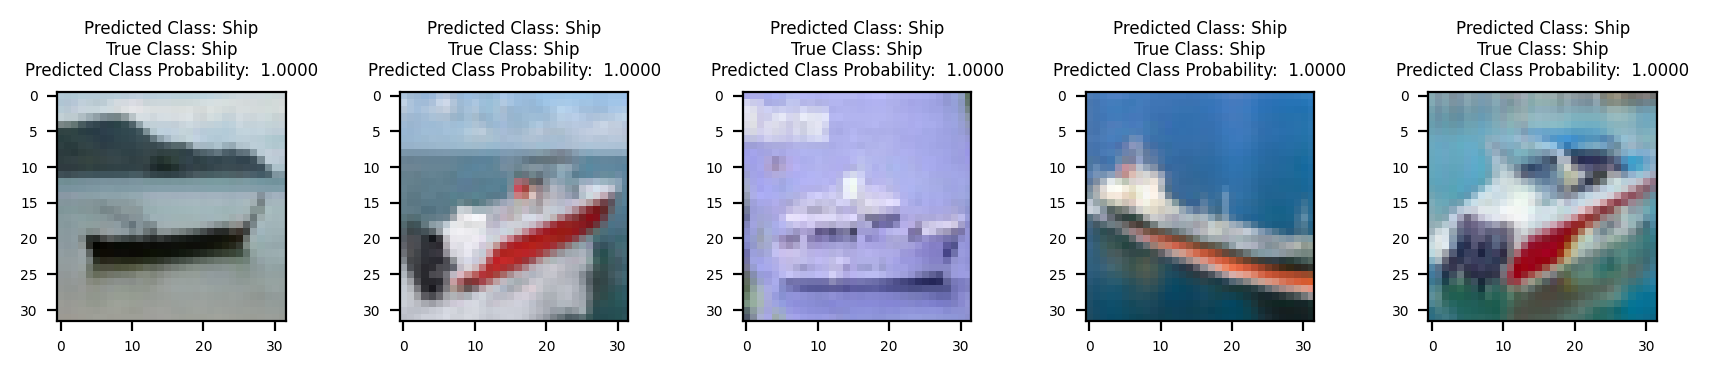

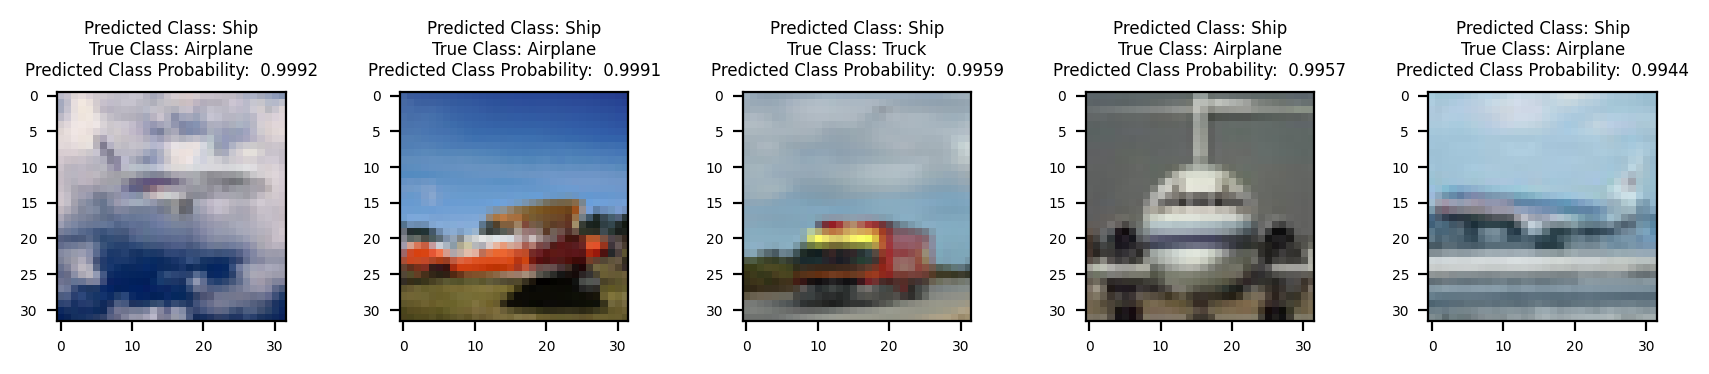

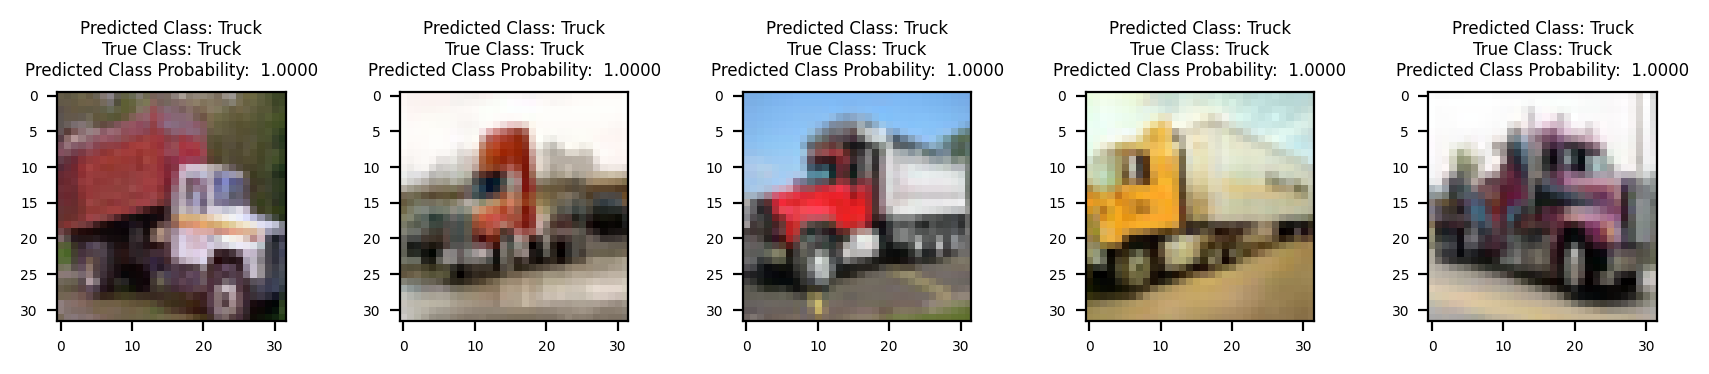

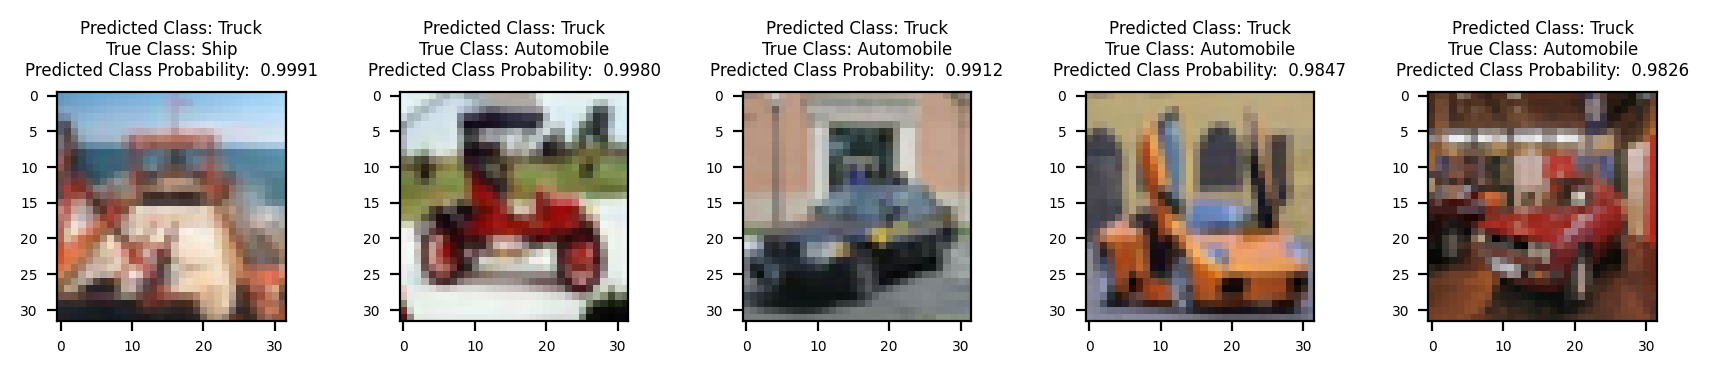

In [23]:
prediction_results(test_results, test_set)

## 2. Movie embeddings

### Data Importation
First, download the movielens (small) [dataset](https://files.grouplens.org/datasets/movielens/ml-latest-small.zip) as `pandas.DataFrame` objects. 

In [ ]:
import torch
from torch import mps
import numpy as np
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# make torch deterministic for reproducibility
torch.manual_seed(576)

# set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Torch Device:", device)

Torch Device: mps


In [ ]:
import pandas as pd

path = "Misc_files/movielens_data/ml-latest-small/"

# load movies and ratings DataFrames
movies = pd.read_csv(path+"movies.csv", header=0)
ratings = pd.read_csv(path+"ratings.csv", header=0)

We can then use the `head()` method to see the raw format of these `DataFrame` objects.

In [ ]:
n_movies = len(movies)

print(f"Number of Unique Movies: {n_movies}")
movies.head()

Number of Unique Movies: 9742


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
n_ratings = len(ratings)
n_users = ratings.userId.nunique()
n_rated_movies = ratings.movieId.nunique()

print(f"Number of Ratings: {n_ratings}\nNumber of Users: {n_users}\nNumber of Unique Rated Movies: {n_rated_movies}")
ratings.head()

Number of Ratings: 100836
Number of Users: 610
Number of Unique Rated Movies: 9724


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Upon inspection of the raw data we note that of the 9,742 movies in the `movies` DataFrame, only 9,724 movies have been rated.

### Preprocessing

#### Embedding Matrix $X$
To obtain the concurrent number of likes $X_{i,j}$ we must first binary encode (`0` or `1`) each `"rating"` in the `ratings` DataFrame. Let us encode the value of liking a movie for each review as such

$$ \text{Liked}(\text{Rating}) =
    \begin{cases}
        1 & \text{if Rating}\geq 4\\
        0 & \text{otherwise}
    \end{cases}$$

and store these values in a new `"liked"` column. We can subsequently drop the unnecessary `rating` and `timestamp` columns after this process.

In [ ]:
# create liked column
ratings["liked"] = np.where(ratings["rating"] >= 4, 1, 0)

# drop columns
ratings.drop(["rating", "timestamp"], axis=1, inplace=True)

We next create the `movie_ratings` DataFrame by joing the `movies` and `ratings` DataFrames. Setting the `merge` method parameter `how="left"` ensures that the original number of movies, 9,742, are maintained after the join.

In [ ]:
# left join on movieId
movie_ratings = pd.merge(movies, ratings, how="left", on="movieId").reset_index()

A user-likes interaction matrix can then be constructed using the `pivot_table` method, whose rows correspond to the number of unique users `n_users` and columns correspond to the number of unique movies `n_movies` from the original data. This results in a sparse matrix whose rows summarize each users liked movies.

In [ ]:
# pivot table on userId
user_likes = movie_ratings.pivot_table(values="liked", index="userId", columns="movieId", dropna=False, fill_value=0)

user_likes

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1.0,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5.0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
607.0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
608.0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Embedding matrix $X$ can now be constructed as the inner (dot) product of the transpose of `user_likes ` and itself. Element $X_{ij} \in X$ corresponds to the number of users that like both movie $i$ and $j$.

In [ ]:
# convert to numpy ndarray for dot product computation
user_likes_array = user_likes.to_numpy()

# create X
X_embedding = np.dot(user_likes_array.T, user_likes_array)

# fill diagonals of X with zeros
np.fill_diagonal(X_embedding, 0)

# display as DataFrame for clarity
X_display = pd.DataFrame(X_embedding, index=movies.movieId, columns = movies.movieId)

X_display

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,
1,0,21,11,0,7,27,7,1,4,19,...,0,0,0,0,0,0,0,0,0,0
2,21,0,5,0,4,8,6,0,0,9,...,0,0,0,0,0,0,0,0,0,0
3,11,5,0,0,4,4,5,1,2,3,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,7,4,4,0,0,3,4,1,1,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
193583,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
193585,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Model Architecture
With preprocessing completed, we convert embedding $X$ into a `torch` tensor object and construct cost function $c$.

In [ ]:
X = torch.tensor(X_embedding, dtype = torch.float32)

We implement the below cost function:
$$c(v_1,\ldots, v_M)=\sum_{i=1}^M\sum_{j=1}^M 1_{[i\neq j]}(v_i^T v_j-X_{i,j})^2$$
by creating a superclass of the `torch` `nn.Module` class.

In [ ]:
import torch.nn as nn

class cost_function(nn.Module):
    def __init__(self):
        super().__init__()
    
    @ classmethod
    def forward(self, v, X):
        # perform main cost function
        costs = ((1 - torch.eye(n_movies)) * (torch.mm(v.t(), v) - X)**2).sum()
        
        return costs

### Training
We can now devise a training loop `train()` and training schema to evaluate different hyperparameters on our cost function.

In [ ]:
# training loop
def train(model, v, X, optimizer, n_epochs=100, verbose = 10):
    
    costs = []
    
    for epoch in tqdm(range(n_epochs)):
        # forward pass
        cost = model.forward(v, X)
        
        # backward pass
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        costs.append(cost.item())
        
        if epoch % verbose == 0:
            print(f"Epoch: {epoch}\tCost: {cost: .5f}")
            
    return costs

# hyperparameters to evaluate
learning_rates = [[1e-5, 1e-6, 1e-7], [1e-4, 1e-3, 1e-1]]
optimizers = ['SGD', 'Adam']

# tracking objects
results = []
trained_vectors = []

# set for epochs
epochs = 20

# Loop over hyperparameters
for optimizer_name in optimizers:
    for lr in learning_rates[optimizers.index(optimizer_name)]: # This is because learning rates are different for each optimizer
        
        # Print configuration hyperparameters
        print(f"Model Configuration:\noptimizer: {optimizer_name}\nlearning rate: {lr}\n")
        
        # Create a new model for each configuration
        v = torch.normal(mean=0, std=0.5, size=(n_movies, n_movies), requires_grad=True)
        model = cost_function()
        model.to(device)

        # Define the optimizer based on the chosen name
        if optimizer_name == 'Adam':
            optimizer = optim.Adam([v], lr=lr)
        elif optimizer_name == 'SGD':
            optimizer = optim.SGD([v], lr=lr, momentum=0.9)

        # Train the model and store the history
        history = train(model, v, X, optimizer, n_epochs=epochs, verbose = 1)

        # Save vectors
        trained_vectors.append(v.detach())

        # Store the results
        result = {
            'learning_rate': lr,
            'optimizer': optimizer_name,
            'loss': history
        }
        
        results.append(result)
        
        print("\n")

Model Configuration:
optimizer: SGD
learning rate: 1e-05



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0	Cost:  57846087680.00000
Epoch: 1	Cost:  25925857280.00000
Epoch: 2	Cost:  9094426624.00000
Epoch: 3	Cost:  5194097152.00000
Epoch: 4	Cost:  4453842432.00000
Epoch: 5	Cost:  3882238976.00000
Epoch: 6	Cost:  4329784320.00000
Epoch: 7	Cost:  6635393024.00000
Epoch: 8	Cost:  8680079360.00000
Epoch: 9	Cost:  8545677824.00000
Epoch: 10	Cost:  7166279680.00000
Epoch: 11	Cost:  5767490560.00000
Epoch: 12	Cost:  4685248512.00000
Epoch: 13	Cost:  3825792000.00000
Epoch: 14	Cost:  3105590784.00000
Epoch: 15	Cost:  2487401728.00000
Epoch: 16	Cost:  1978133376.00000
Epoch: 17	Cost:  1614578048.00000
Epoch: 18	Cost:  1403468800.00000
Epoch: 19	Cost:  1291588480.00000


Model Configuration:
optimizer: SGD
learning rate: 1e-06



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0	Cost:  57864118272.00000
Epoch: 1	Cost:  53506084864.00000
Epoch: 2	Cost:  46263369728.00000
Epoch: 3	Cost:  37891858432.00000
Epoch: 4	Cost:  29815445504.00000
Epoch: 5	Cost:  22868414464.00000
Epoch: 6	Cost:  17346486272.00000
Epoch: 7	Cost:  13193802752.00000
Epoch: 8	Cost:  10187829248.00000
Epoch: 9	Cost:  8065057792.00000
Epoch: 10	Cost:  6585990656.00000
Epoch: 11	Cost:  5558555136.00000
Epoch: 12	Cost:  4839370240.00000
Epoch: 13	Cost:  4326042112.00000
Epoch: 14	Cost:  3947599872.00000
Epoch: 15	Cost:  3656063488.00000
Epoch: 16	Cost:  3419867648.00000
Epoch: 17	Cost:  3218896896.00000
Epoch: 18	Cost:  3040728320.00000
Epoch: 19	Cost:  2877847808.00000


Model Configuration:
optimizer: SGD
learning rate: 1e-07



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0	Cost:  57829216256.00000
Epoch: 1	Cost:  57380368384.00000
Epoch: 2	Cost:  56538959872.00000
Epoch: 3	Cost:  55364489216.00000
Epoch: 4	Cost:  53916807168.00000
Epoch: 5	Cost:  52253724672.00000
Epoch: 6	Cost:  50429288448.00000
Epoch: 7	Cost:  48492527616.00000
Epoch: 8	Cost:  46486769664.00000
Epoch: 9	Cost:  44449308672.00000
Epoch: 10	Cost:  42411446272.00000
Epoch: 11	Cost:  40398749696.00000
Epoch: 12	Cost:  38431494144.00000
Epoch: 13	Cost:  36525236224.00000
Epoch: 14	Cost:  34691383296.00000
Epoch: 15	Cost:  32937781248.00000
Epoch: 16	Cost:  31269339136.00000
Epoch: 17	Cost:  29688543232.00000
Epoch: 18	Cost:  28195932160.00000
Epoch: 19	Cost:  26790545408.00000


Model Configuration:
optimizer: Adam
learning rate: 0.0001



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0	Cost:  57861603328.00000
Epoch: 1	Cost:  57809428480.00000
Epoch: 2	Cost:  57757310976.00000
Epoch: 3	Cost:  57705234432.00000
Epoch: 4	Cost:  57653202944.00000
Epoch: 5	Cost:  57601228800.00000
Epoch: 6	Cost:  57549295616.00000
Epoch: 7	Cost:  57497415680.00000
Epoch: 8	Cost:  57445588992.00000
Epoch: 9	Cost:  57393811456.00000
Epoch: 10	Cost:  57342078976.00000
Epoch: 11	Cost:  57290407936.00000
Epoch: 12	Cost:  57238781952.00000
Epoch: 13	Cost:  57187213312.00000
Epoch: 14	Cost:  57135697920.00000
Epoch: 15	Cost:  57084235776.00000
Epoch: 16	Cost:  57032822784.00000
Epoch: 17	Cost:  56981475328.00000
Epoch: 18	Cost:  56930177024.00000
Epoch: 19	Cost:  56878936064.00000


Model Configuration:
optimizer: Adam
learning rate: 0.001



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0	Cost:  57817743360.00000
Epoch: 1	Cost:  57298370560.00000
Epoch: 2	Cost:  56783540224.00000
Epoch: 3	Cost:  56273293312.00000
Epoch: 4	Cost:  55767658496.00000
Epoch: 5	Cost:  55266689024.00000
Epoch: 6	Cost:  54770397184.00000
Epoch: 7	Cost:  54278807552.00000
Epoch: 8	Cost:  53791940608.00000
Epoch: 9	Cost:  53309820928.00000
Epoch: 10	Cost:  52832452608.00000
Epoch: 11	Cost:  52359839744.00000
Epoch: 12	Cost:  51891998720.00000
Epoch: 13	Cost:  51428917248.00000
Epoch: 14	Cost:  50970603520.00000
Epoch: 15	Cost:  50517041152.00000
Epoch: 16	Cost:  50068221952.00000
Epoch: 17	Cost:  49624137728.00000
Epoch: 18	Cost:  49184776192.00000
Epoch: 19	Cost:  48750104576.00000


Model Configuration:
optimizer: Adam
learning rate: 0.1



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0	Cost:  57831776256.00000
Epoch: 1	Cost:  24206647296.00000
Epoch: 2	Cost:  11583097856.00000
Epoch: 3	Cost:  6867374592.00000
Epoch: 4	Cost:  5088110080.00000
Epoch: 5	Cost:  4321560576.00000
Epoch: 6	Cost:  3866012928.00000
Epoch: 7	Cost:  3477851392.00000
Epoch: 8	Cost:  3092493824.00000
Epoch: 9	Cost:  2715210240.00000
Epoch: 10	Cost:  2367997184.00000
Epoch: 11	Cost:  2064991488.00000
Epoch: 12	Cost:  1808596992.00000
Epoch: 13	Cost:  1597054208.00000
Epoch: 14	Cost:  1423815296.00000
Epoch: 15	Cost:  1277813376.00000
Epoch: 16	Cost:  1149398528.00000
Epoch: 17	Cost:  1033291648.00000
Epoch: 18	Cost:  927278208.00000
Epoch: 19	Cost:  829560448.00000




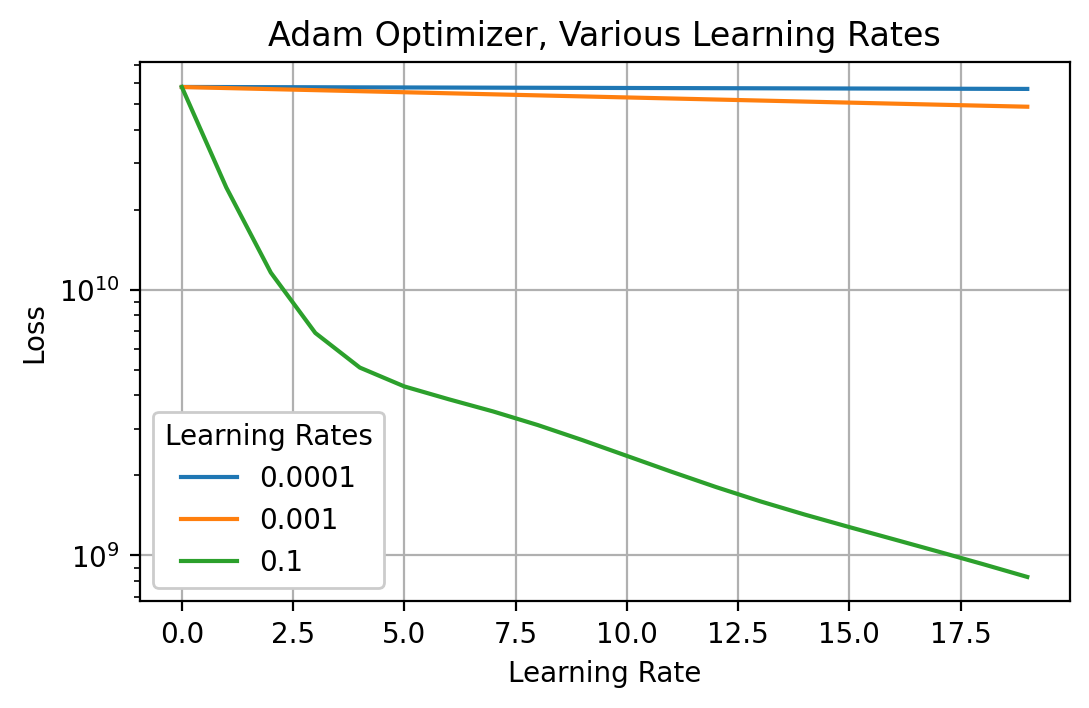

In [ ]:

def plot_losses(results):
    
    fig, ax = plt.subplots(figsize=(6,3.5), dpi=200)
    
    optimizer_name = results[0]["optimizer"]
    
    ax.set_title(f"{optimizer_name} Optimizer, Various Learning Rates")
    
    for result in results:
        ax.plot(result["loss"], label=result["learning_rate"])

    # Add labels and legend
    ax.set_xlabel('Epochs') # I changed it from Learning rate to epochs
    ax.set_ylabel('Loss')
    ax.set_yscale('log')
    legend = ax.legend(title='Learning Rates', loc='best')
    legend.get_frame().set_alpha(1.0)

    # Show the plot
    ax.grid(True)

plot_losses(results[3:])

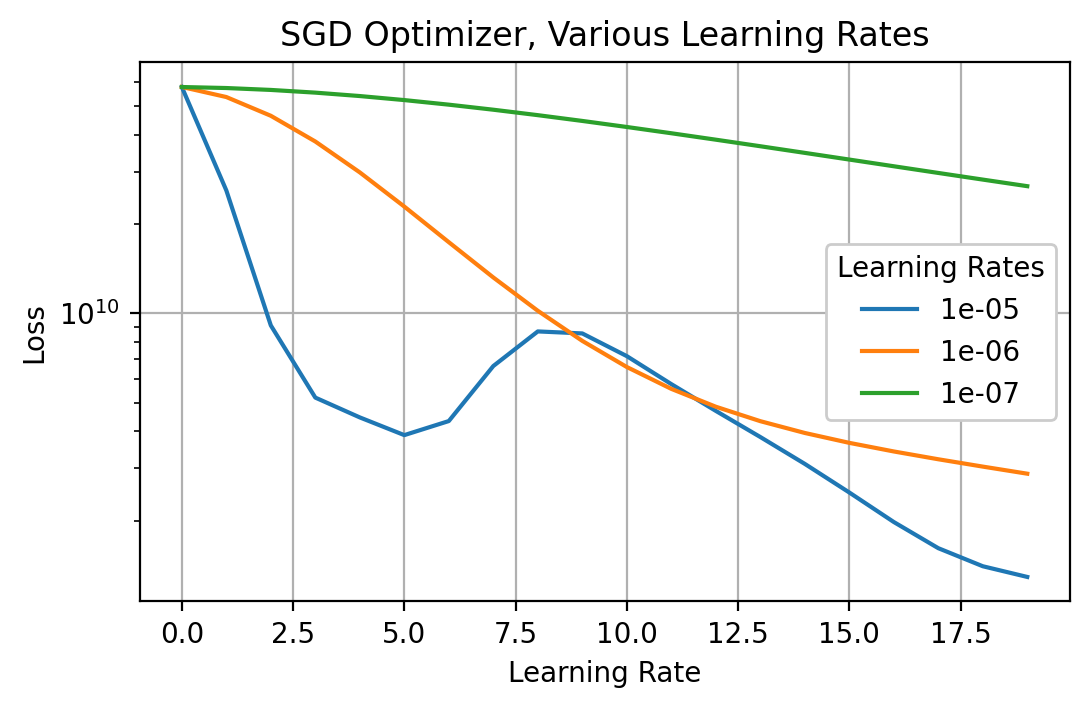

In [ ]:
plot_losses(results[:3])

### Functions to recommend top N movies
We defined a function to recommend top N movies based on input movies

It first finds the indices of the input movies in the list of all movie titles.
Next, it calculates the average similarity scores for the input movies by taking the mean of the cosine similarity scores of their embeddings.
The code then excludes the input movies from consideration by setting their similarity scores to a negative value.
It identifies the top N recommended movies by sorting the similarity scores and selecting the top N indices.
Finally, it retrieves the names of the recommended movies based on the indices and returns them.

In [ ]:
# Calculate movie similarities using cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

# Function to recommend top N movies based on input movies
def recommend_movies(input_movies, movie_names, movie_similarities, top_n=10):
    # Find the indices of input movies
    input_indices = [movie_names.index(movie) for movie in input_movies]

    # Calculate the average similarity scores for input movies
    input_similarity_scores = np.mean(movie_similarities[input_indices], axis=0)

    # Exclude input movies from consideration
    input_similarity_scores[input_indices] = -1.0  # Set similarity score to a negative value

    # Get indices of top N recommended movies
    top_indices = np.argsort(input_similarity_scores)[-top_n:][::-1]

    # Get the names of recommended movies
    recommended_movies = [movie_names[i] for i in top_indices]

    return recommended_movies

In [ ]:
def get_recommendation(movies, embedding):

    # Calculate cosine similarity between movie embeddings
    movie_similarities = cosine_similarity(embedding)

    # The input movies
    input_movies = ["Apollo 13 (1995)", "Toy Story (1995)", "Home Alone (1990)"]

    # Get recommended movies and print the results
    for input_movie in input_movies:
        recommended_movies = recommend_movies([input_movie], movies['title'].tolist(), movie_similarities)
        print(f"Recommended Movies for '{input_movie}':")
        for i, movie in enumerate(recommended_movies, start=1):
            print(f"{i}. {movie}")
        print()

#### Recommend top 10 movies
given movies (a) Apollo 13, (b) Toy Story, and (c) Home Alone. 

The reuslts are below. The code prints the recommended movies given each three of the movies along with a header that indicates the learning rate and optimizer used for the embedding.

In [ ]:
learning_rates = [[1e-5, 1e-6, 1e-7], [1e-4, 1e-3, 1e-1]]
optimizers = ['SGD', 'Adam']

headers = []  # The list of trained vectors
trained_index = 0
for optimizer in optimizers:
    for lr in learning_rates[optimizers.index(optimizer)]:
        header = f"The result of Learning Rate: {lr}, Optimizer: {optimizer} -----------------"
        print(header + "\n")
        embedding = trained_vectors[trained_index]
        get_recommendation(movies, embedding)
        trained_index += 1 

The result of Learning Rate: 1e-05, Optimizer: SGD -----------------

Recommended Movies for 'Apollo 13 (1995)':
1. Eichmann (2007)
2. Crows Zero (Kurôzu zero) (2007)
3. Hitch (2005)
4. She's So Lovely (1997)
5. Oscar (1991)
6. Love at First Bite (1979)
7. Whole Ten Yards, The (2004)
8. In the Name of the Father (1993)
9. Wasp Woman, The (1959)
10. Last Night (1998)

Recommended Movies for 'Toy Story (1995)':
1. Lone Star (1996)
2. Wizard, The (1989)
3. Battle for the Planet of the Apes (1973)
4. Special Day, A (Giornata particolare, Una) (1977)
5. Element of Crime, The (Forbrydelsens Element) (1984)
6. Last Airbender, The (2010)
7. Apollo 18 (2011)
8. Yi Yi (2000)
9. Bow, The (Hwal) (2005)
10. Paths of Glory (1957)

Recommended Movies for 'Home Alone (1990)':
1. Romper Stomper (1992)
2. Mimic (1997)
3. Bungo Stray Dogs: Dead Apple (2018)
4. Jabberwocky (1977)
5. Skyfall (2012)
6. Apocalypse Now (1979)
7. Blade Runner (1982)
8. RKO 281 (1999)
9. Stage Fright (1950)
10. Jobs (2013)

The

#### Describe your recommendation strategy.
The recommendation strategy involves using movie embeddings and cosine similarity to recommend movies based on a set of input movies. The cosine similarity is done by comparing the embeddings (vector representations) of different movies to measure how similar they are in terms of their content or characteristics.


This strategy allows us to explore different combinations of learning rates and optimizers to generate movie embeddings. For each combination, it provides movie recommendations based on the content of the input movies.

#### Do the recommendations change when you change learning rates or optimizers? Why or why not?

The changes in learning rates and optimizers can potentially lead to different embeddings, and consequently, different movie recommendations. 
* Learning Rates: Learning rates determine the step size during the optimization process (e.g., gradient descent) when training. If changing the learning rate impacts the training process or results in different embeddings, then the recommendations may change. 

* Optimizers: Different optimization algorithms, such as Adam and SGD, have different update rules for adjusting model parameters during training. These algorithms can have an impact on how the model learns and the final embeddings it produces.